# Analysis of SIT and Sentinel - 2 level 2A Bottom of Atmosphere (BOA) reflectances 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import rasterio
from glob import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio.warp as warp
from rasterio.transform import Affine
from rasterio.merge import merge
import rasterio.mask
from rasterio.enums import Resampling
from affine import Affine
from pyproj import Proj, transform
import shapely.wkt
from shapely.geometry import mapping
import dateparser
import cv2
import numpy as np
from geojson import Polygon, FeatureCollection, GeometryCollection, Feature, dump
from datetime import timedelta
from sentinelhub import WmsRequest, AwsProductRequest, BBox, CRS, MimeType, CustomUrlParam, get_area_dates, geo_utils
import warnings
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
from sentinelsat import SentinelAPI, geojson_to_wkt
warnings.filterwarnings("ignore")

def overlay_cloud_mask(image, ax, mask=None):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    print(image.shape)
    ax.imshow(image.transpose(1,2,0))
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([0, 255, 255, 100], dtype=np.uint8)
        ax.imshow(cloud_image)
        
navgemGray = glob(os.path.join(r"E:\MastersProjectData\SIT_met",'*color_500.tif'))
ncepGray = glob(os.path.join(r'.\sentinel4thinice_ncep_500', 'ncep','500','*color_500.tif'))

# Cloud Detection
##### Creating cloud masks for each merged S-2 product

In [4]:
S2_overlapped = glob(os.path.join(r'E:\MastersProjectData\SIT_S2','*slstr*'))
S2cloudless_bands = [0, 1, 3, 4, 7, 8, 9, 10, 11, 12]
masks = {}
dates = []

for S2 in S2_overlapped:
    
    if len(os.listdir(S2))==0:
        
        continue
    SITname = os.path.basename(S2)+'.tif'
    
    for SIT_ in navgemGray:
        name = os.path.basename(SIT_)
        if SITname == name:
            SIT = SIT_
        else:
            continue
    
    S2_merged = os.path.join(S2, 'Merged_S1C', 'merged.tif')
    dates.append(os.path.basename(SIT)[:22])
    
    with rasterio.open(S2_merged) as src:
        data = src.read()
    
    data = np.expand_dims(data[S2cloudless_bands], axis=0).transpose(0, 2, 3, 1)
    
    masks[os.path.basename(SIT)[:22]] = S2PixelCloudDetector(threshold=0.3, dilation_size=3).get_cloud_masks(data)

<IPython.core.display.Javascript object>


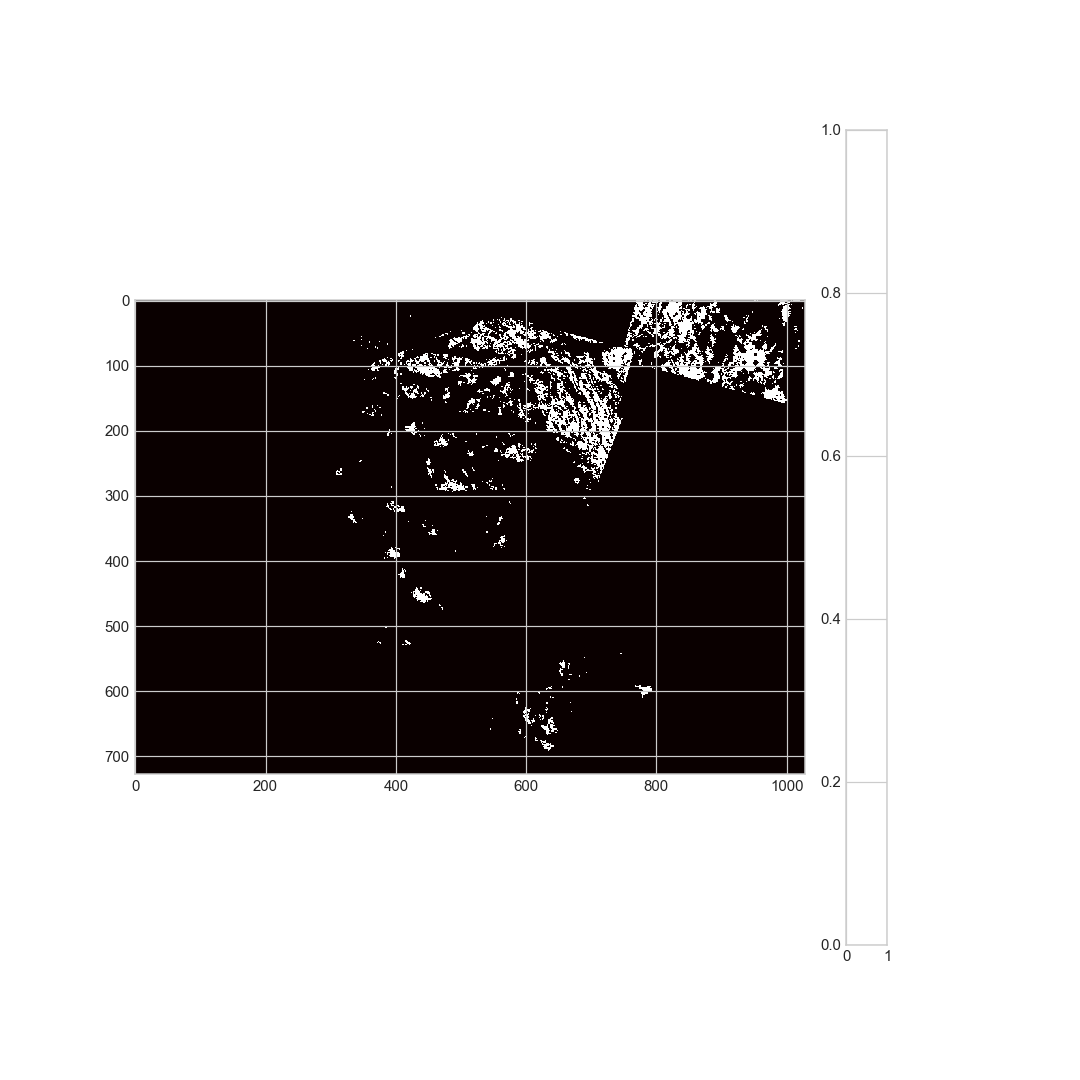

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [89]:
%matplotlib notebook
S2_overlapped = glob(os.path.join(r'E:\MastersProjectData\SIT_S2','*slstr*'))
S2_merged = os.path.join(S2_overlapped[0], 'Merged_ACOLITE', 'merged.tif')
with rasterio.open(S2_merged) as src:
    data = src.read()
    thin_ice = np.copy(SIT_image[0])
    data[np.isnan(data)]=0
    data[:,(data[1]<=0.0) | (masks[dates[0]][0] == 1)] = 0
    #thin_ice[(data[1]==0.0) | (masks[dates[0]][0] == 1)] = 0
    vals1 = data[:, (data[0]>0.0) & (masks[dates[0]][0] != 1)]
    vals2 = data[:, (data[0]>0.0)]
    thin_ice_roi = thin_ice[492:1220, 1509:2537]
    thick_ice = thin_ice_roi == 90
    thin_ice_roi[(thin_ice_roi < 101) | (thin_ice_roi>130)] = 0
    data = data[:,492:1220, 1509:2537]
    #thick_ice[(data[1]==0.0)] = 0
    thin_ice_roi -= 100
    thick_ice[data[1]==0] = False

plt.figure(figsize=(10,10))
plt.imshow(thick_ice, cmap='hot')
plt.colorbar()
plt.show()


# Testing snow mask:

<IPython.core.display.Javascript object>


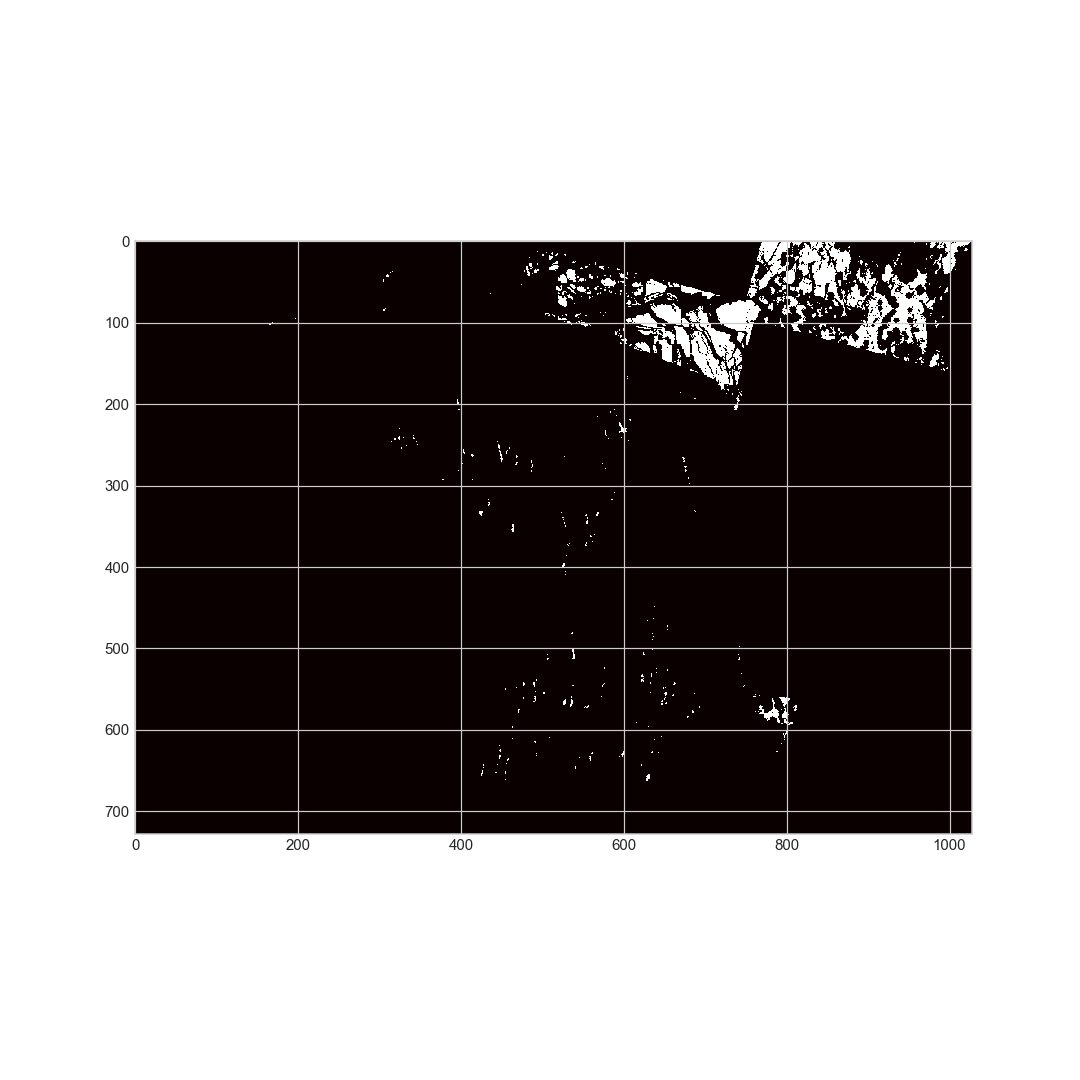

<IPython.core.display.Javascript object>


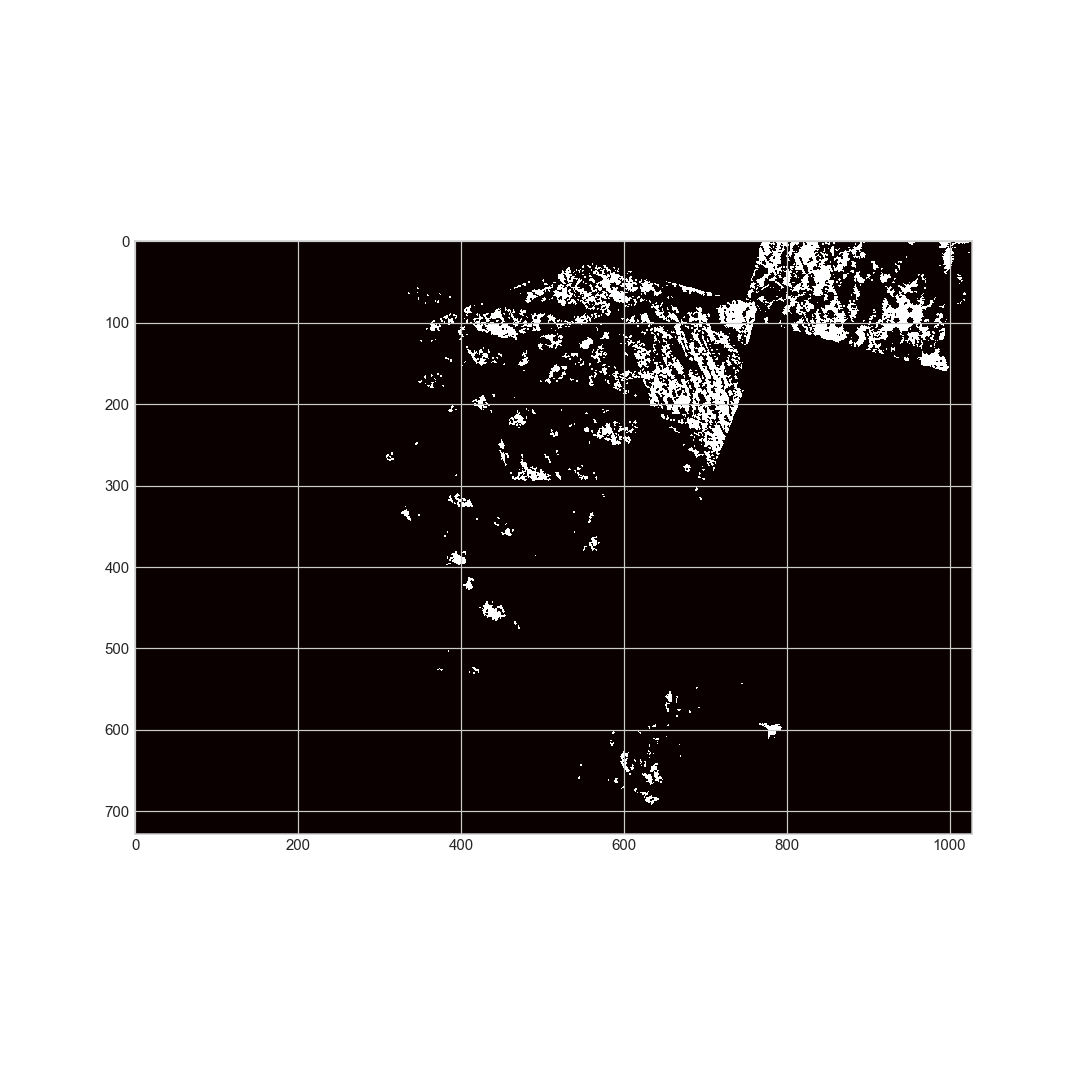

<IPython.core.display.Javascript object>


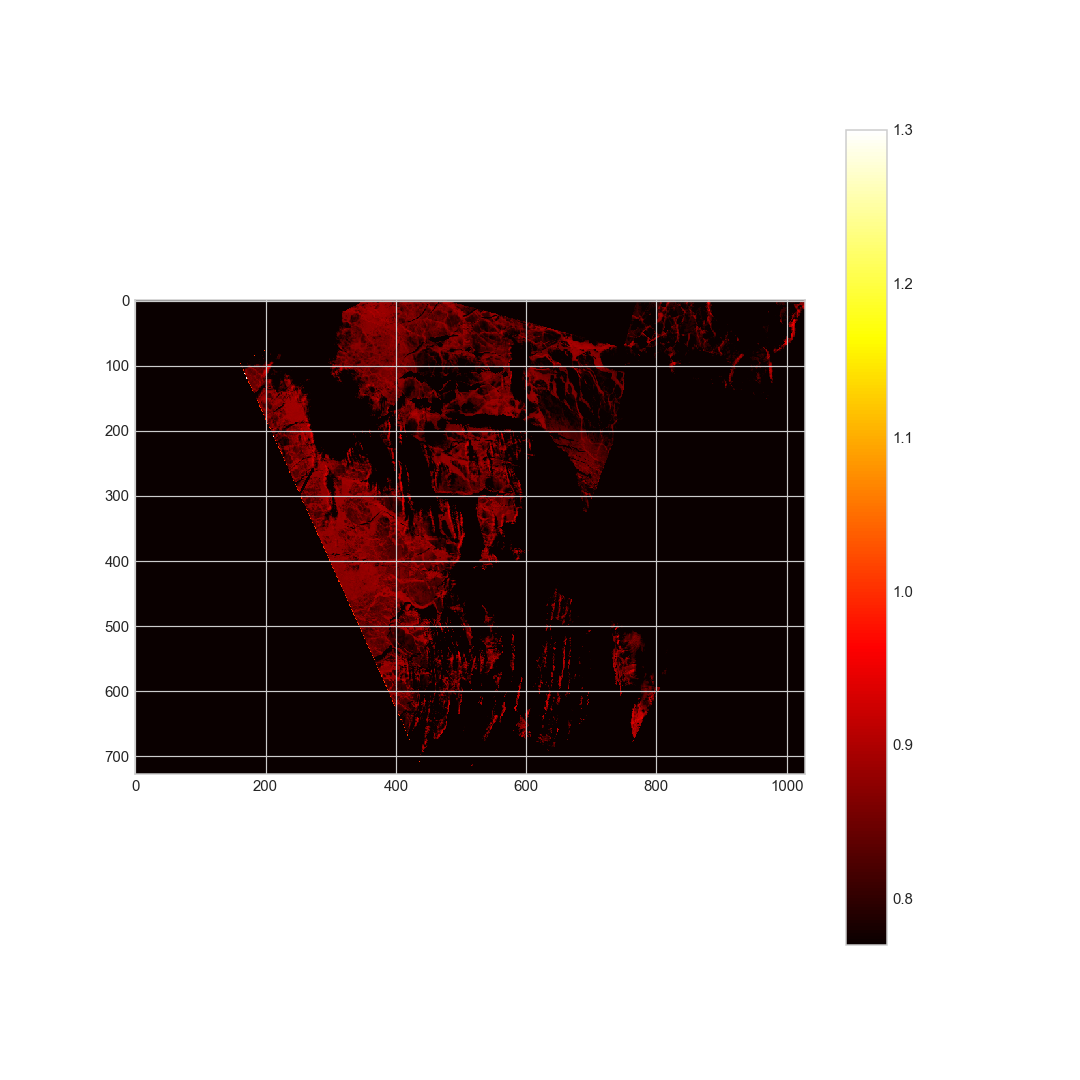

<IPython.core.display.Javascript object>


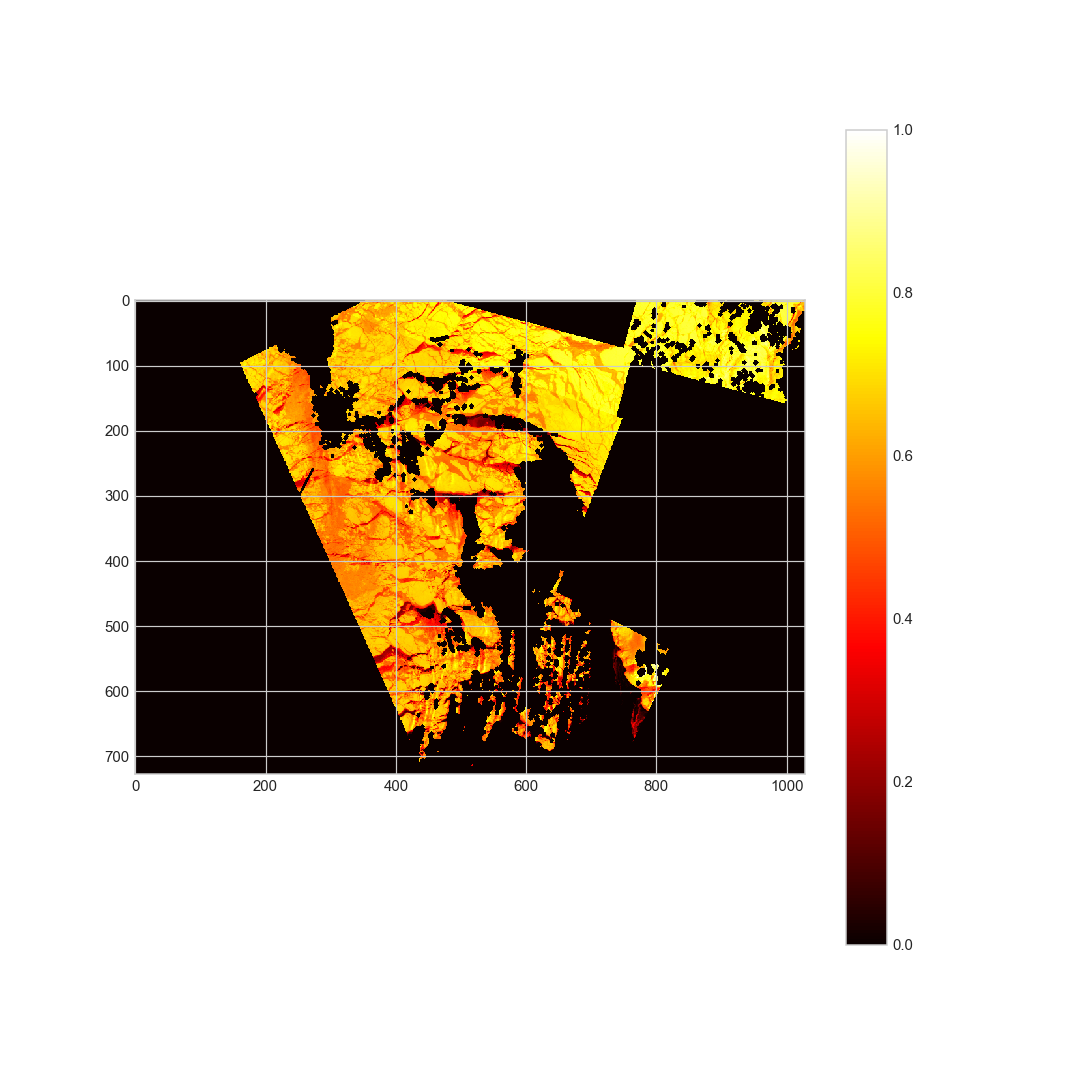

In [90]:
NDSI = np.zeros((data.shape[1],data.shape[2]))
snow1 = np.zeros_like(NDSI, dtype=np.bool)
snow2 = np.zeros_like(snow1, dtype=np.bool)
snow = np.zeros_like(snow2, dtype=np.bool)
val_vals = data[0]>0.0

NDSI[~val_vals]=0
snow1[~val_vals]=False
snow2[~val_vals]=False
snow[~val_vals]=False
NDSI[val_vals] = (data[2, val_vals]-data[9, val_vals])/(data[2, val_vals]+data[9, val_vals])

N1 = 0.8
R1 = 0.74
#R2 = 0.7

snow[val_vals] = (NDSI[val_vals] < N1) & (data[0, val_vals] > R1)

thick_ice_data = data[:, thick_ice]
plt.figure(figsize=(10,10))
plt.imshow(snow, cmap='hot')
plt.figure(figsize=(10,10))
plt.imshow(thick_ice, cmap='hot')
plt.figure(figsize=(10,10))
plt.imshow(NDSI, cmap='hot', vmin=0.77, vmax=1.3)
plt.colorbar()
plt.figure(figsize=(10,10))
plt.imshow(data[0], cmap='hot', vmin=0, vmax=1)
plt.colorbar()

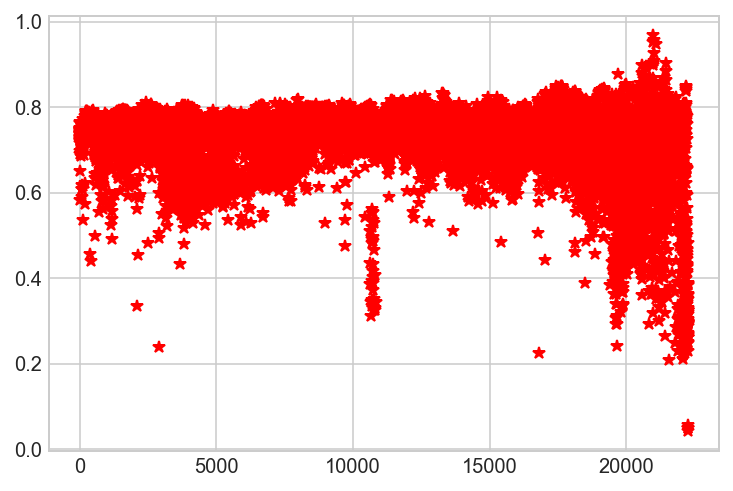

In [332]:
plt.figure()
plt.plot(thick_ice_data[7,:], 'r*')

# SIT Pixels extraction
##### Finding the valid Sentinel - 2 pixels and the extractring the SIT information with the corresponding S2 band reflectances

In [80]:
S2_overlapped = glob(os.path.join(r'E:\MastersProjectData\SIT_S2','*slstr*'))

thin_ice_S2 = []
thick_ice_S2 = []
thin_SIT_vals=[]
SIT_image = []
S2_image = []
dates = []
i = 0
for S2 in S2_overlapped:
    if len(os.listdir(S2))==0:
        continue
    SITname = os.path.basename(S2)+'.tif'
    for SIT_ in navgemGray:
        name = os.path.basename(SIT_)
        if SITname == name:
            SIT = SIT_
        else:
            continue
    S2_merged = os.path.join(S2, 'Merged_ACOLITE', 'merged.tif')
    date = os.path.basename(SIT)[:22]
    dates.append(date)
    with rasterio.open(SIT) as SITraster:
        thin_ice= SITraster.read(1)
        with rasterio.open(S2_merged) as S2raster:
            data_set = S2raster.read()
            data_set[np.isnan(data_set)]=0
            data_set[data_set<=0.0] = 0
            data_set[:,masks[dates[-1]][0] == 1] = 0
            S2_image.append(data_set.transpose(1,2,0))
            valid_pixels = (data_set[0] > 0.0) & (data_set[1] > 0.0) & (data_set[2] > 0.0) & (data_set[3] > 0.0) & (data_set[4] > 0.0) &\
            (data_set[5] > 0.0) & (data_set[6] > 0.0) & (data_set[7] > 0.0) & (data_set[8] > 0.0) & (data_set[9] > 0.0) & (data_set[10] > 0.0) 
            valid_thin_ice = thin_ice[valid_pixels]
            thick_ice = valid_thin_ice == 90
            valid_S2 = data_set[:, valid_pixels]
            thin_ice_index = (valid_thin_ice > 100) & (valid_thin_ice <= 130)
            thin_ice_vals = valid_thin_ice[thin_ice_index] - 100
            thin_ice_S2_valid = valid_S2[:, thin_ice_index].transpose(1,0)
            thick_ice_S2_valid = valid_S2[:, thick_ice].transpose(1,0)
    thin_ice_S2.append(thin_ice_S2_valid)
    thick_ice_S2.append(thick_ice_S2_valid)
    thin_SIT_vals.append(thin_ice_vals)
    SIT_image.append(thin_ice)
    

S2_sit_array = np.concatenate(thin_ice_S2)
S2_thickit_array = np.concatenate(thick_ice_S2)
thin_SIT_vals_arr = np.concatenate(thin_SIT_vals)


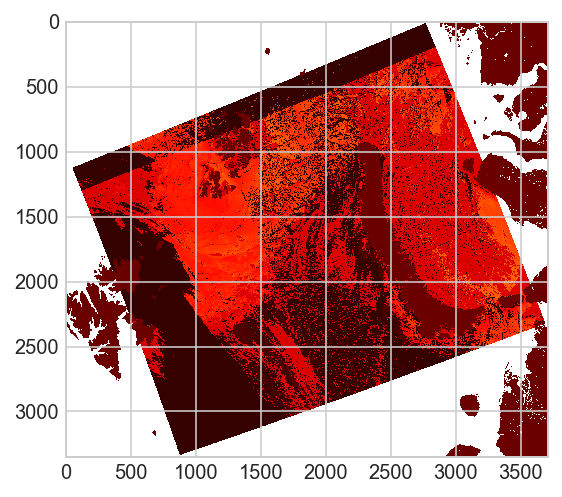

In [73]:
plt.figure()
plt.imshow(SIT_image[0], cmap='hot')

# Visualizing each SIT spectra

Text(0.5, 1.0, 'Overview of SIT BOA spectras for each thickness')

<Figure size 432x288 with 0 Axes>

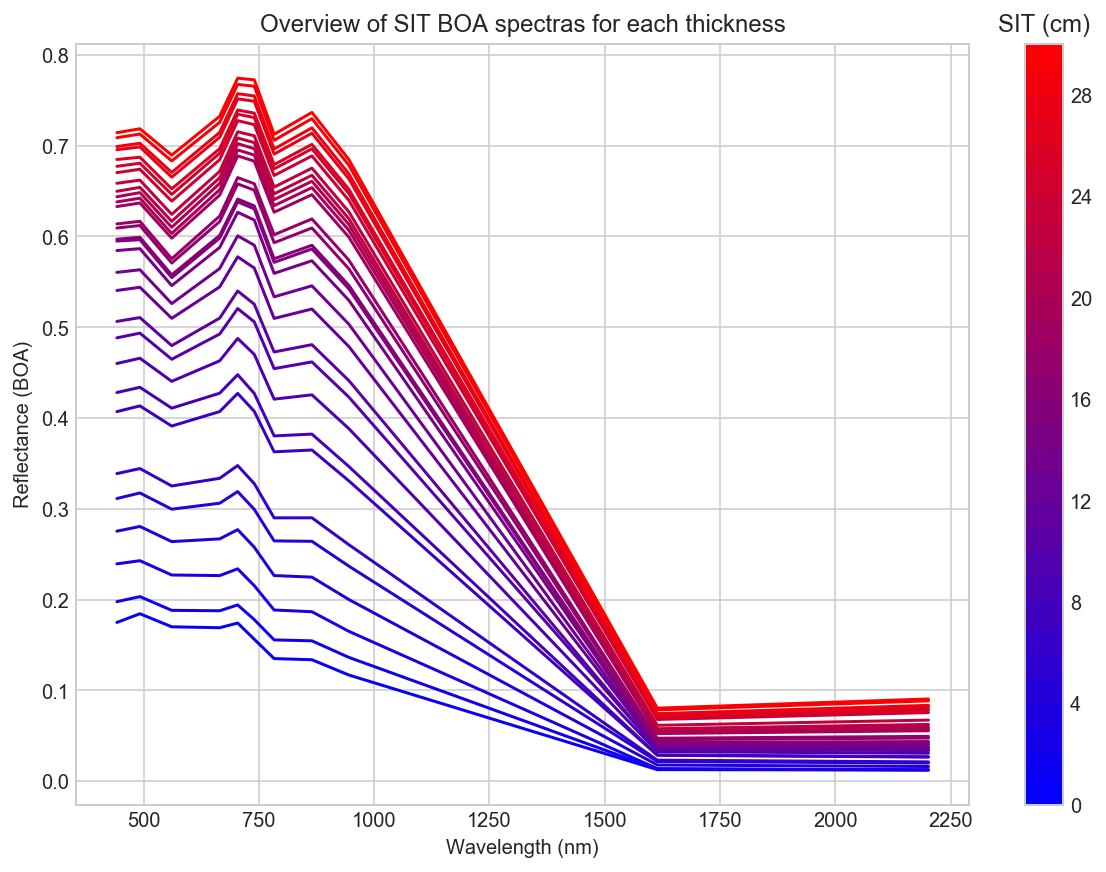

In [12]:
import matplotlib as mpl
min_, max_ = (0, 30)
step = 1

# Setting up a colormap that's a simple transtion
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min_,max_+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

plt.style.use('seaborn-whitegrid')
thin_ice_vals_iter, counts = np.unique(thin_SIT_vals_arr, return_counts=True)

lambda_bands1C = [442, 492, 561, 665, 704, 740, 783, 833, 865, 945, 1373, 1614, 2202]
lambda_bands2A = [442, 492, 561, 665, 704, 740, 783, 865, 945, 1614, 2202]
cmap = plt.get_cmap('jet_r')
N = 50
plt.figure(figsize=(10, 7))
for i, cmval in enumerate(thin_ice_vals_iter):
    r = (float(cmval)-min_)/(max_-min_)
    g = 0
    b = 1-r
    thin_ice_cm = thin_SIT_vals_arr == cmval
    thin_ice_S2_cm = np.mean(S2_sit_array[thin_ice_cm,:], axis=0)
    plt.plot(lambda_bands2A, thin_ice_S2_cm, c=(r, g, b), label='{} cm'.format(cmval))

clb = plt.colorbar(CS3)
clb.ax.set_title('SIT (cm)')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (BOA)')
plt.title("Overview of SIT BOA spectras for each thickness")

# SIT as a function of band reflectances

<IPython.core.display.Javascript object>


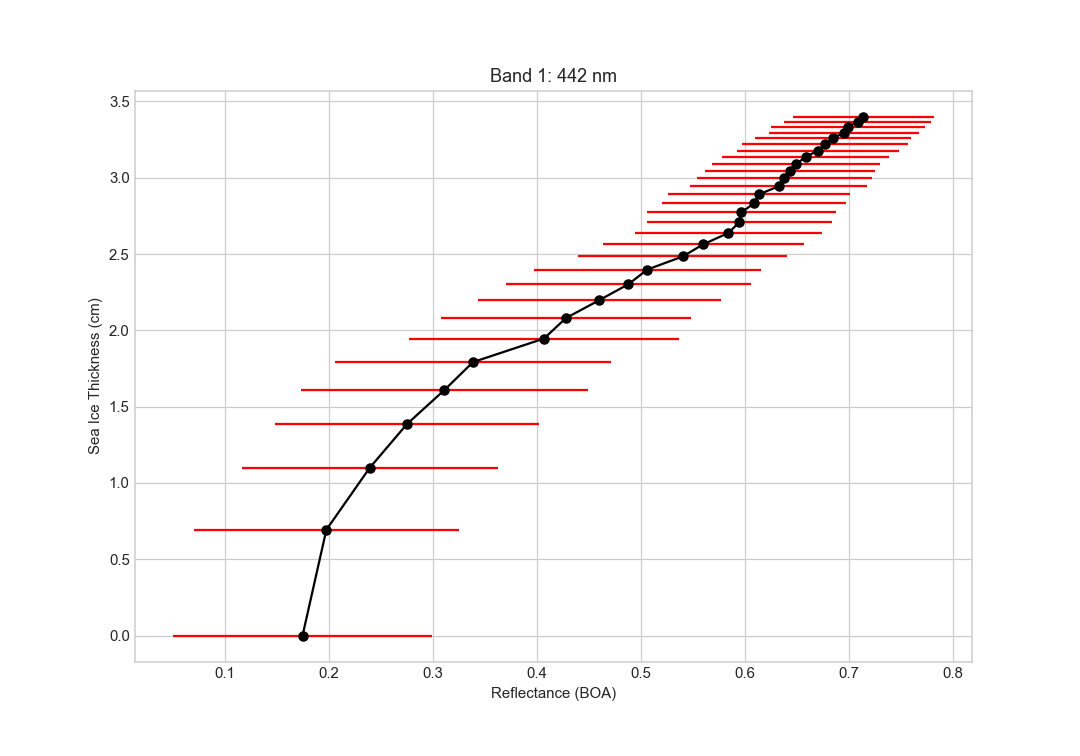

<IPython.core.display.Javascript object>


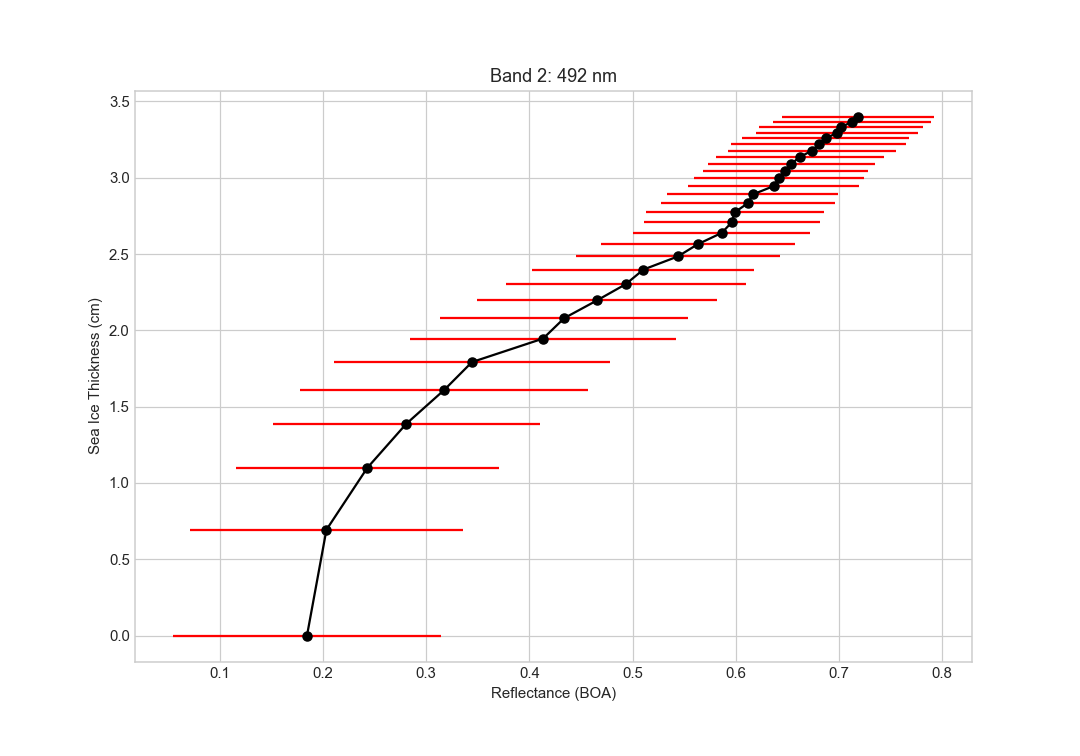

<IPython.core.display.Javascript object>


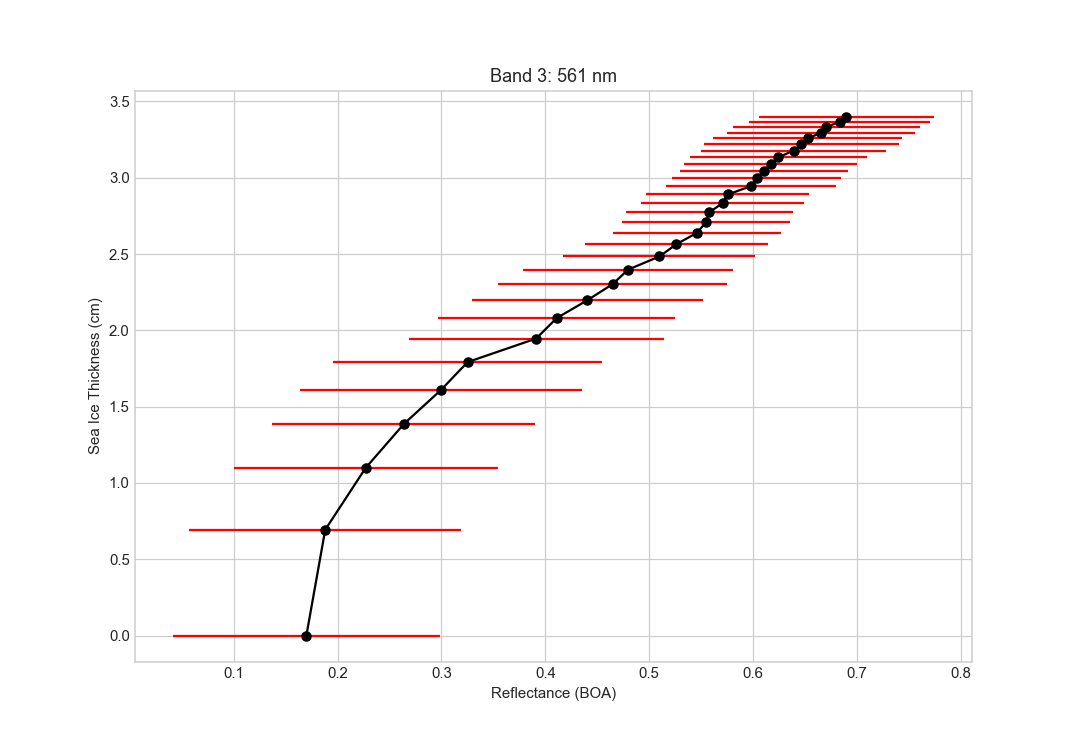

<IPython.core.display.Javascript object>


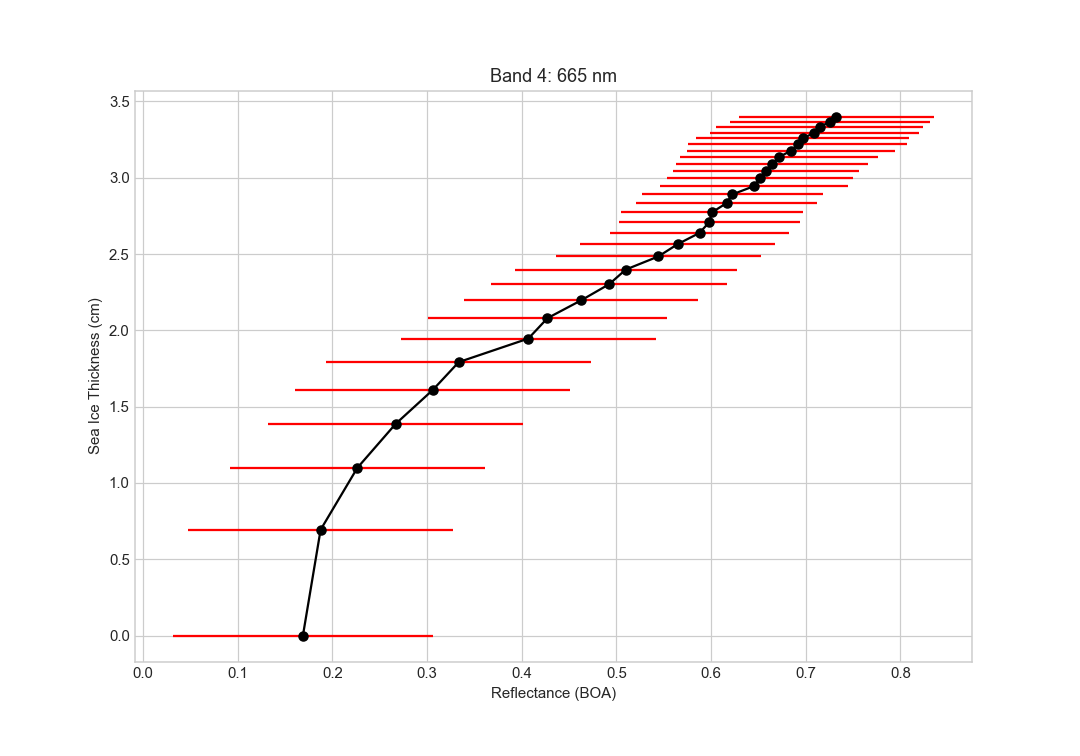

<IPython.core.display.Javascript object>


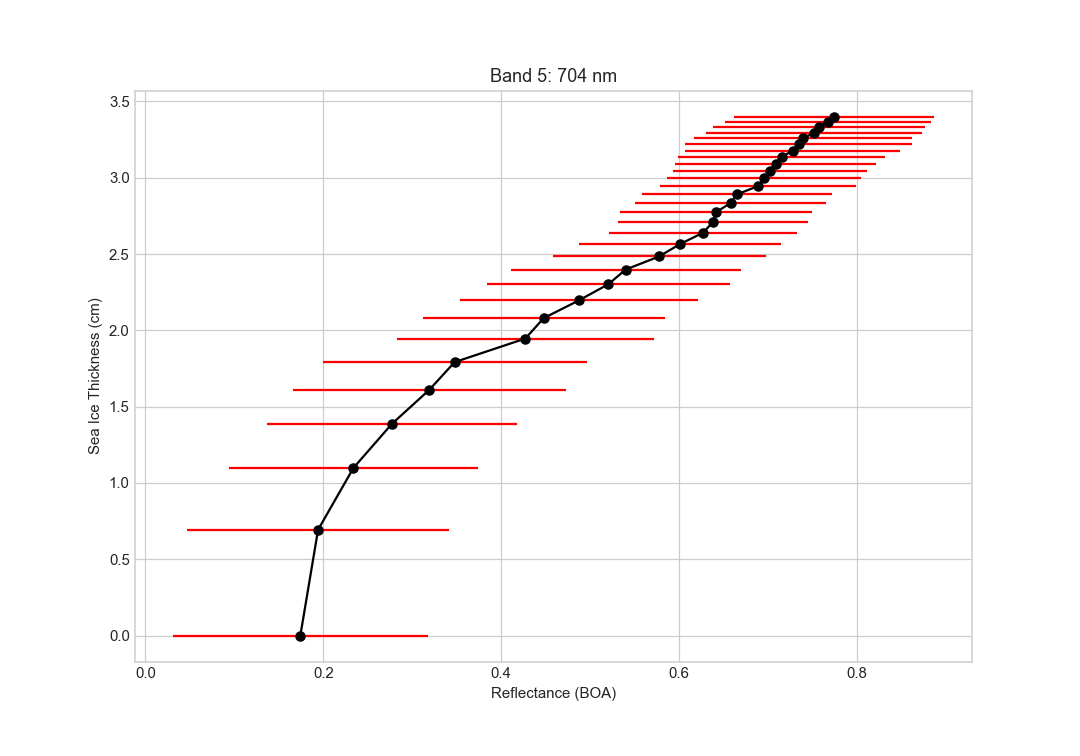

<IPython.core.display.Javascript object>


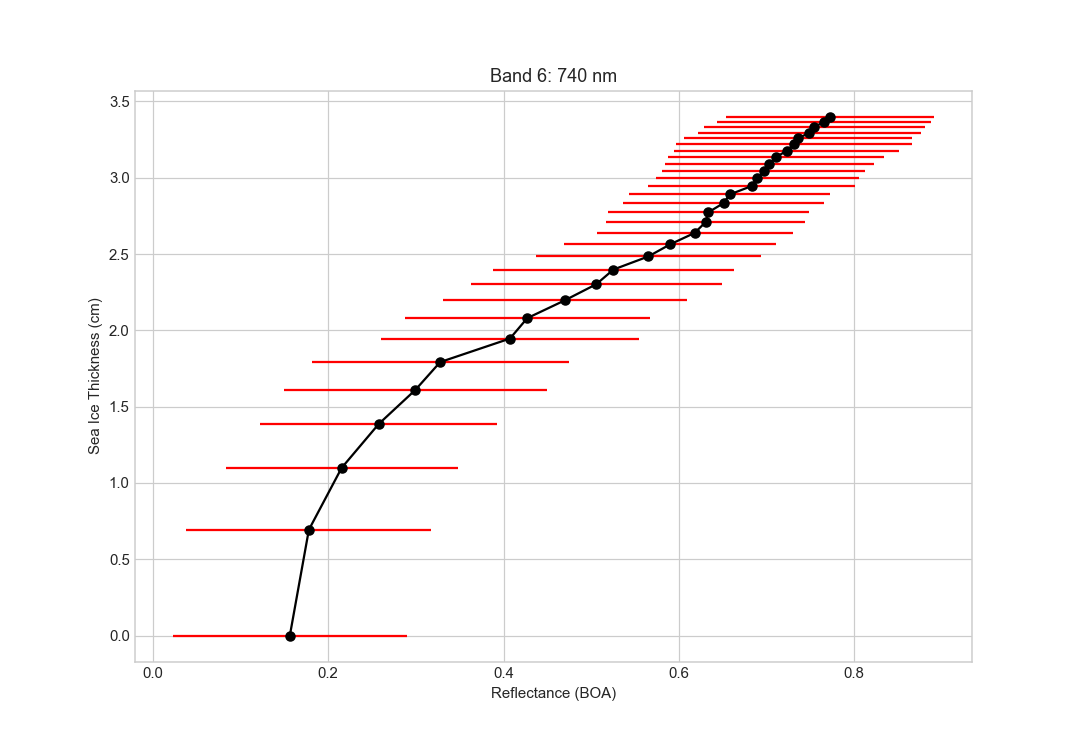

<IPython.core.display.Javascript object>


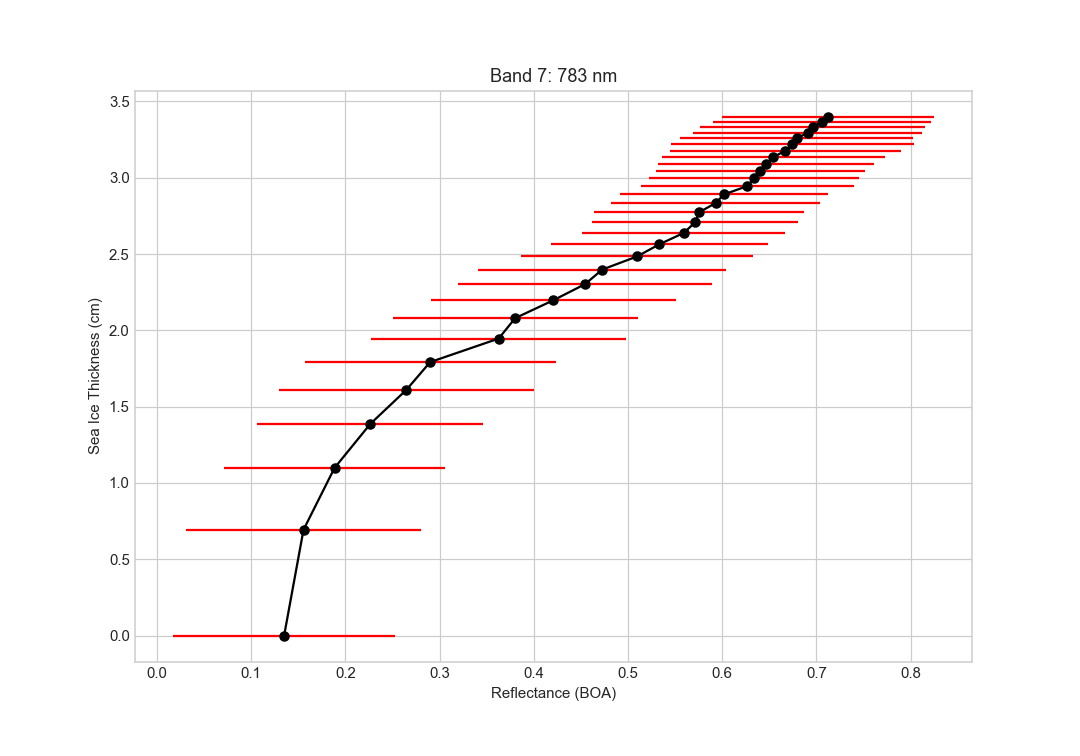

<IPython.core.display.Javascript object>


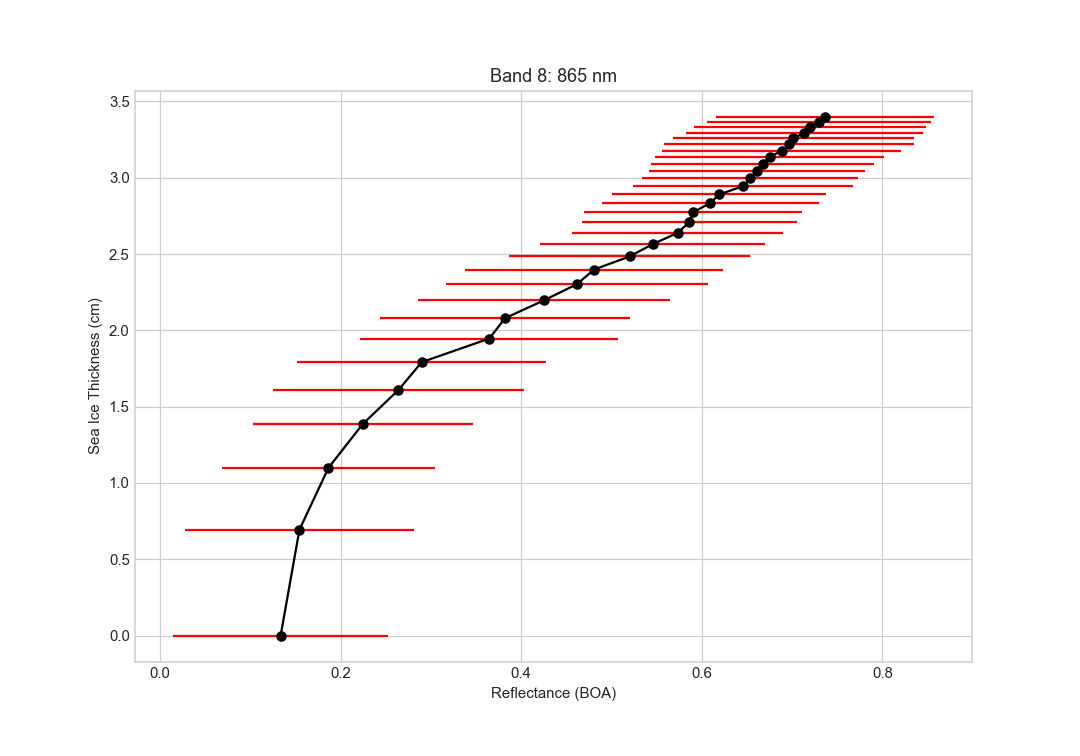

<IPython.core.display.Javascript object>


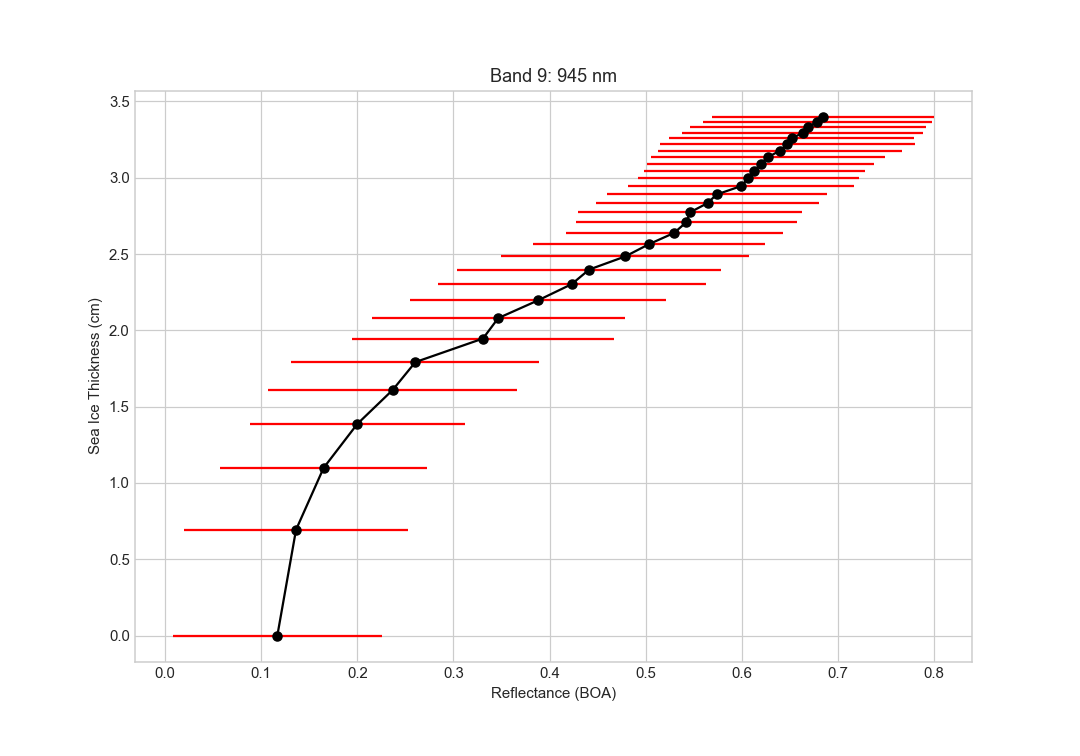

<IPython.core.display.Javascript object>


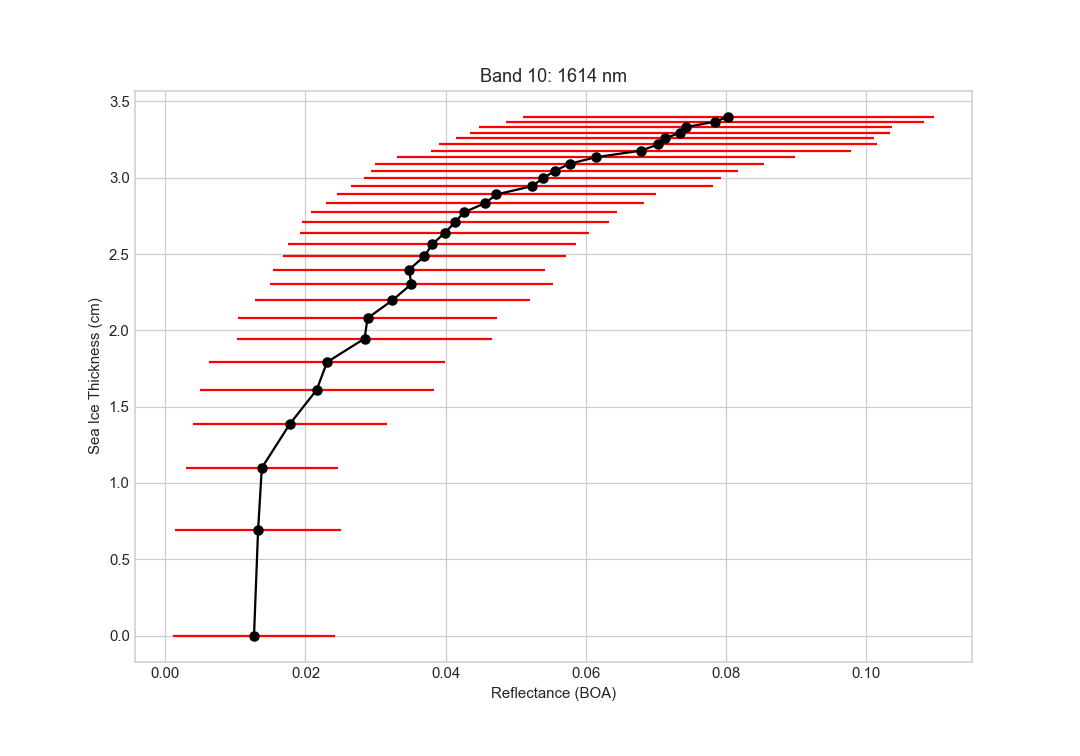

<IPython.core.display.Javascript object>


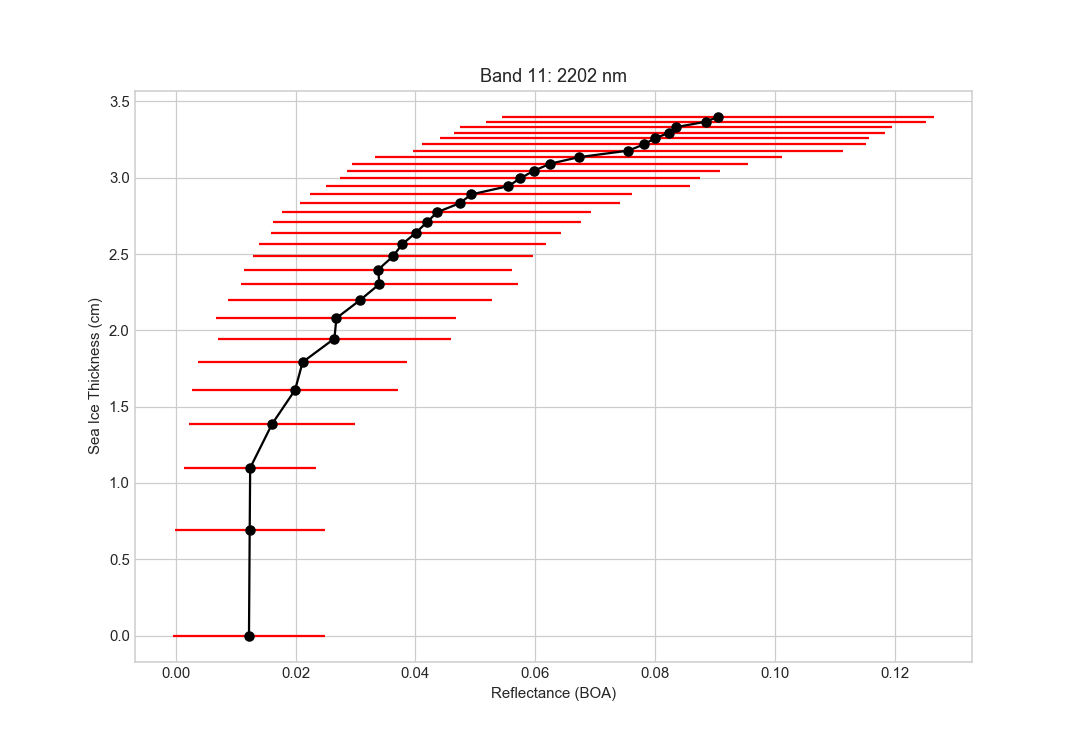

In [93]:

cmap = plt.get_cmap('jet_r')
thin_ice_vals_iter, counts = np.unique(thin_SIT_vals_arr, return_counts=True)
mean_vals = []
sigma = []
N=20
for i, band in enumerate(range(11)):
    standard_var_band = []
    mean_band = []
    color = cmap(float(i)/N)
    for j, cmval in enumerate(thin_ice_vals_iter):
        thin_ice_cm = thin_SIT_vals_arr == cmval
        mean_band.append(np.mean(S2_sit_array[thin_ice_cm, band]))
        standard_var_band.append(np.std(S2_sit_array[thin_ice_cm, band]))
    sigma.append(standard_var_band)
    mean_vals.append(mean_band)
    plt.figure(figsize=(10, 7))
    plt.errorbar(mean_band, np.log(thin_ice_vals_iter), xerr=standard_var_band, fmt='-ok', ecolor='r')
    plt.title('Band {}: {} nm'.format(i+1, lambda_bands2A[i]))
    plt.ylabel('Sea Ice Thickness (cm)')
    plt.xlabel('Reflectance (BOA)')
    
#ax.set_xlabel('Reflectance')
#ax.legend()
#ax.set_ylabel('Sea Ice Thickness (cm)')
#ax.set_xlabel('Reflectance')

# Difference between SIT/Band reflectance relation of different products

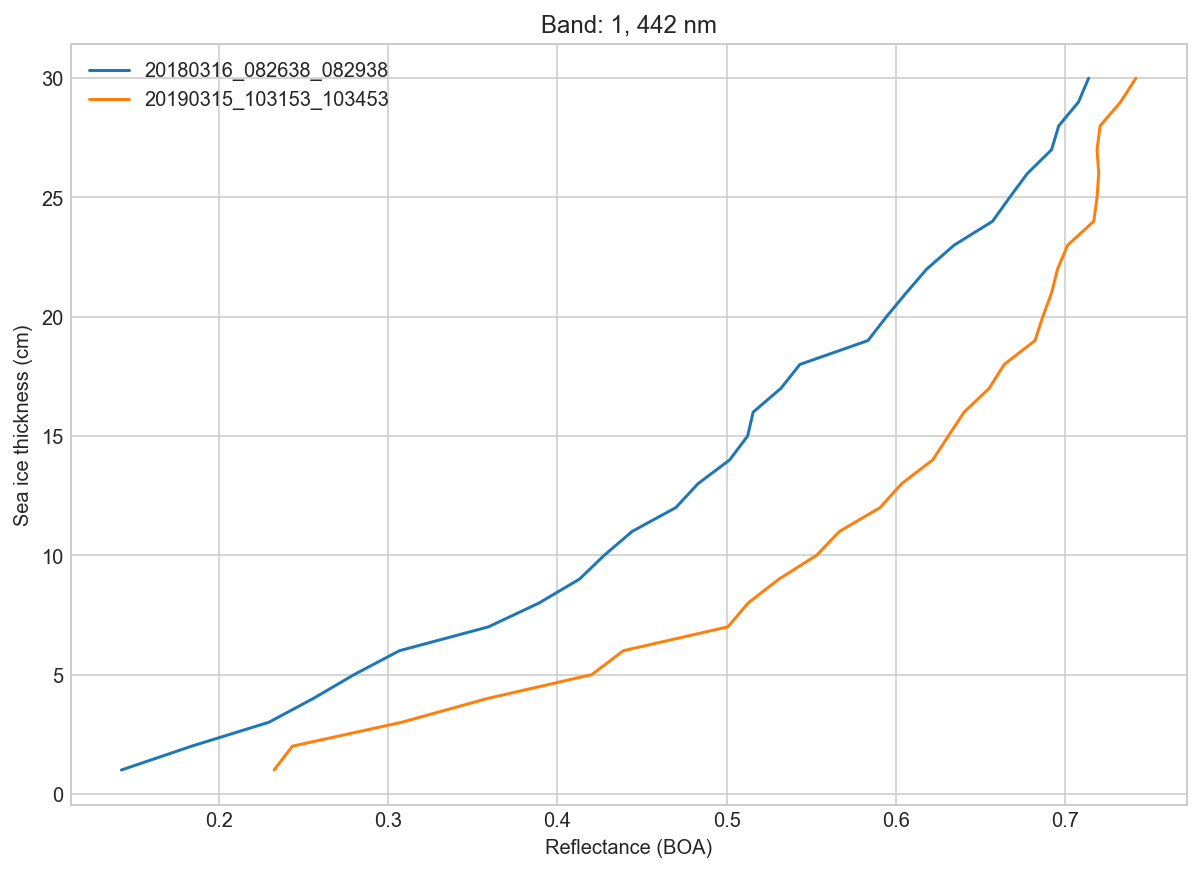

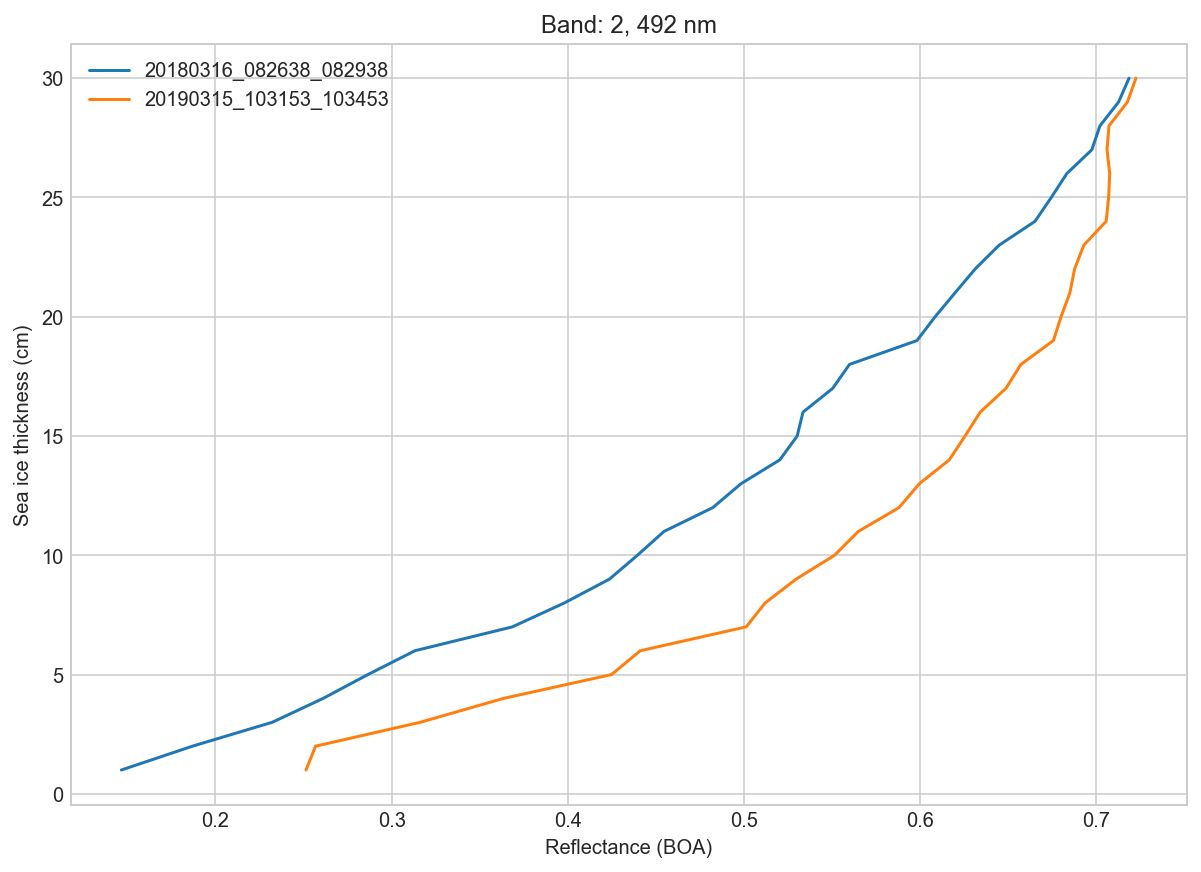

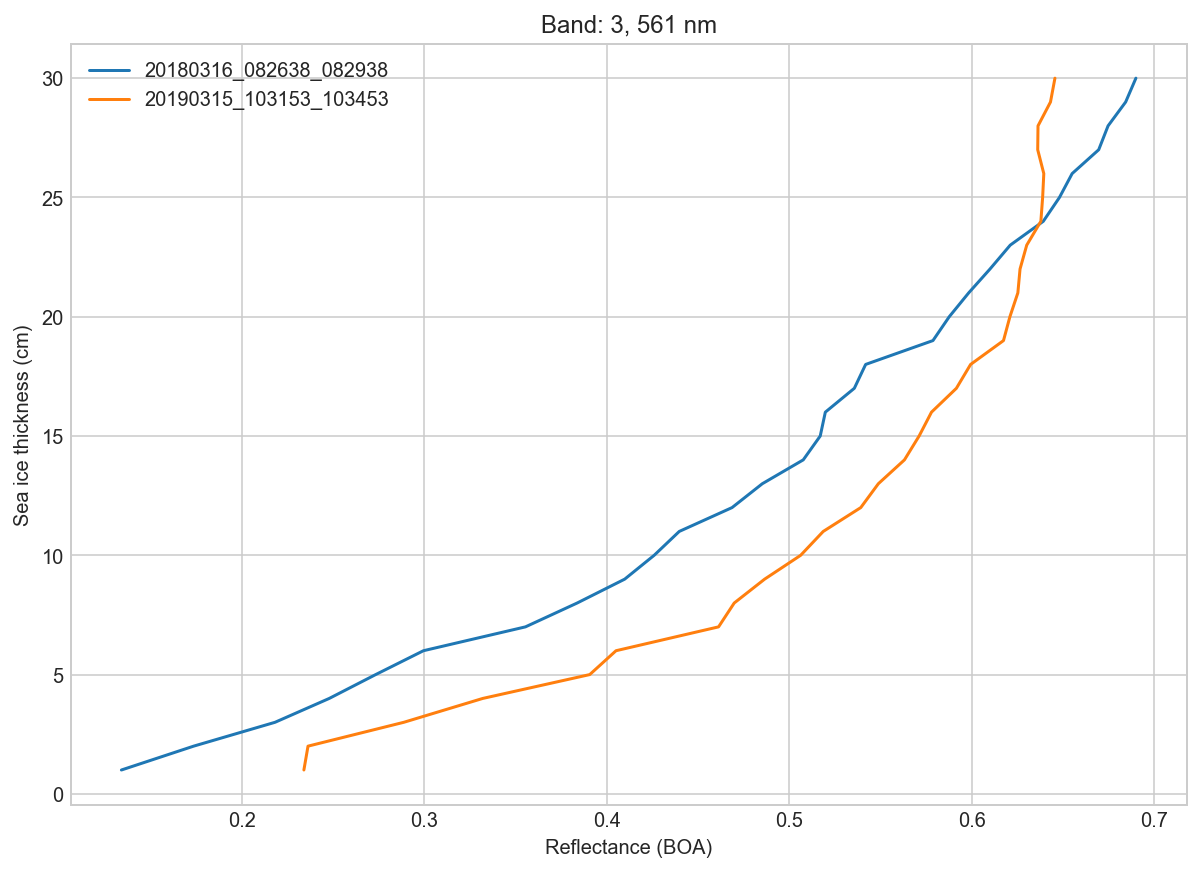

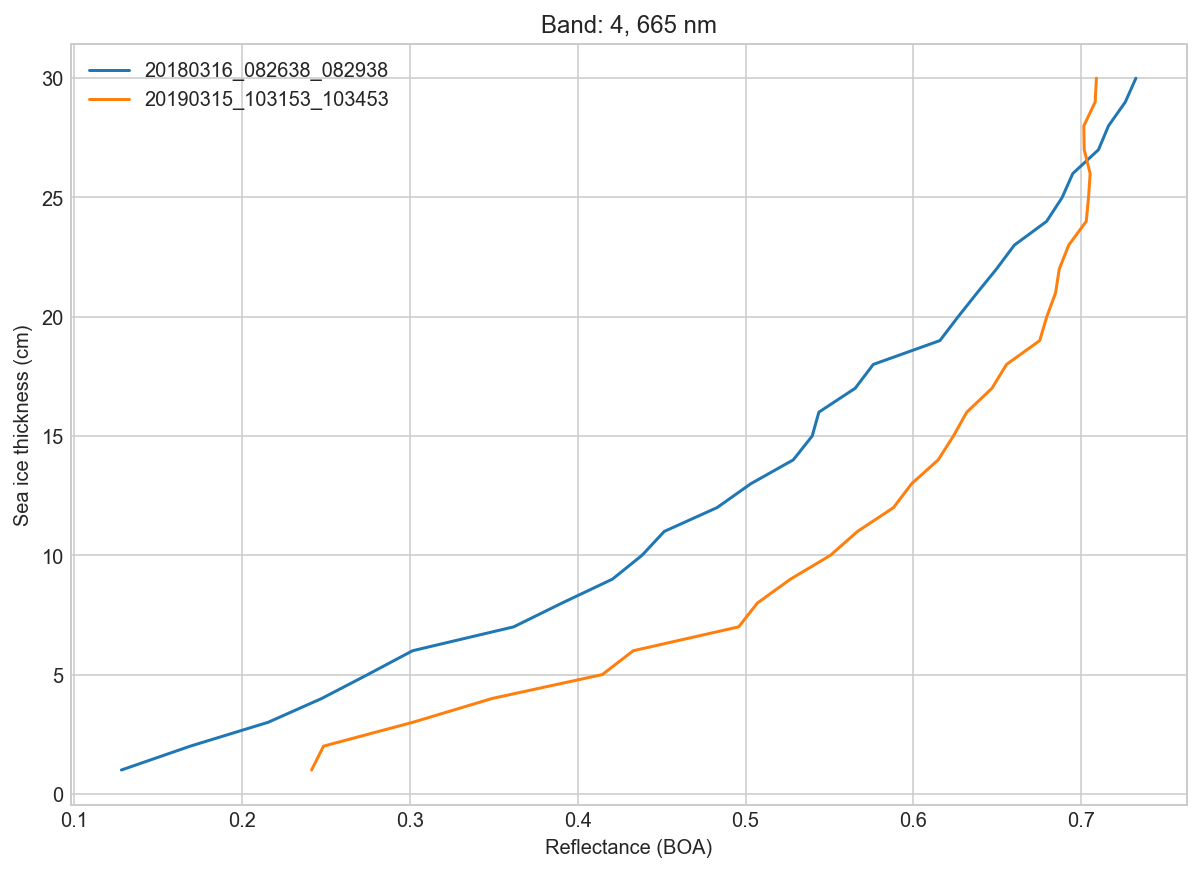

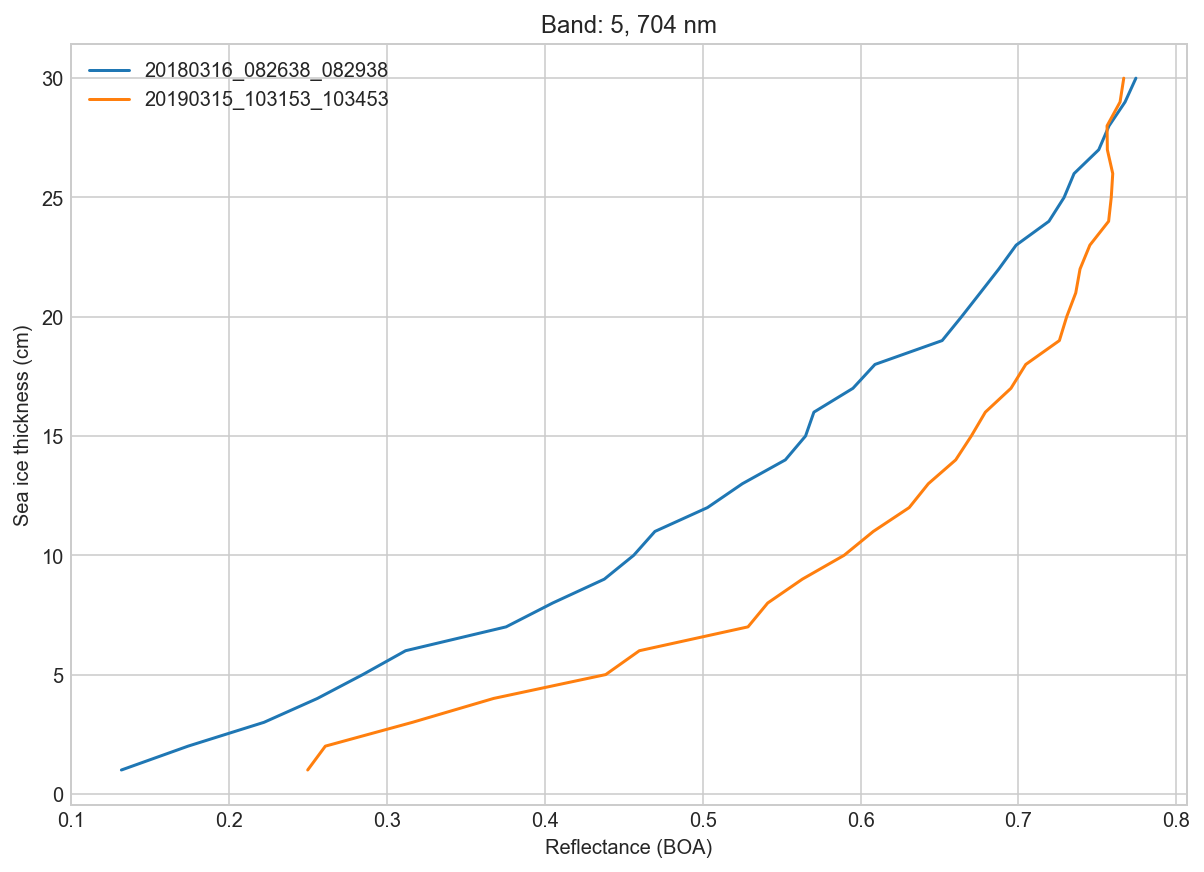

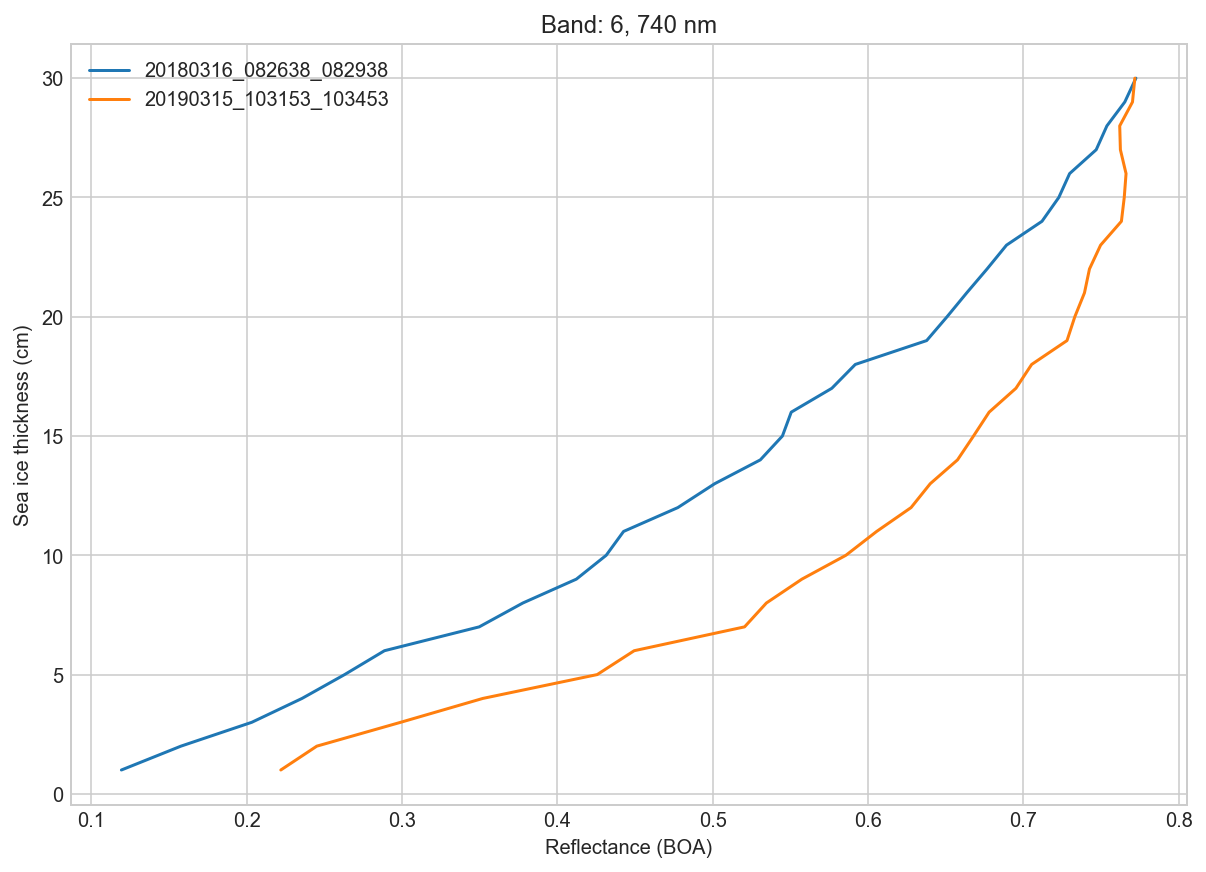

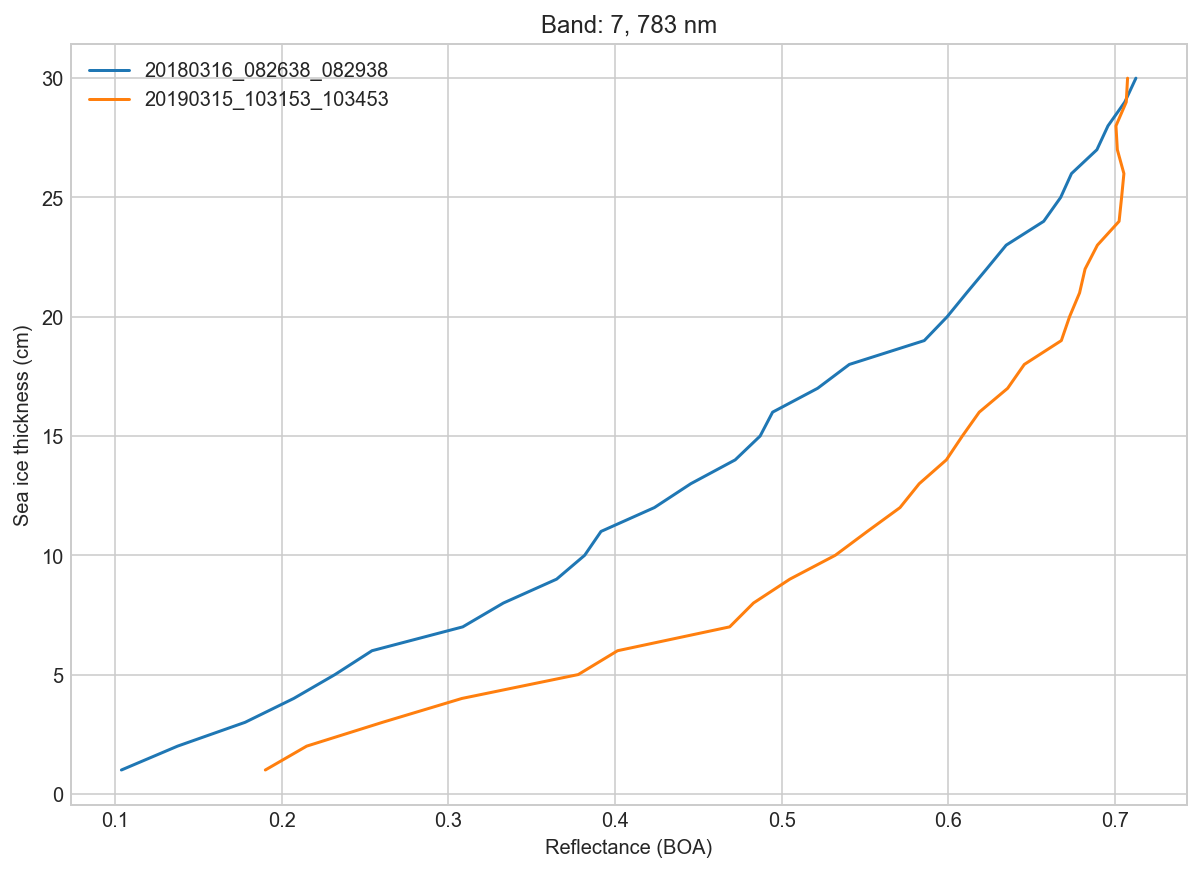

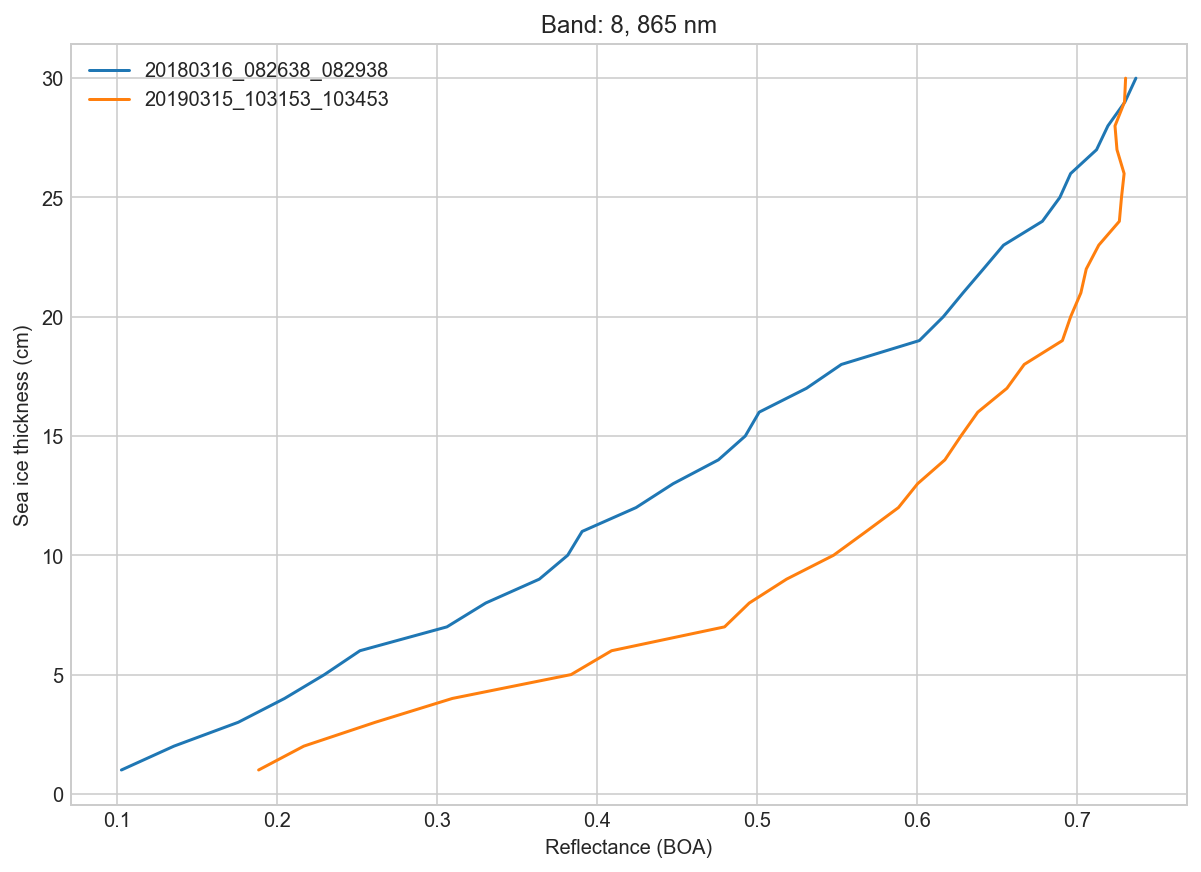

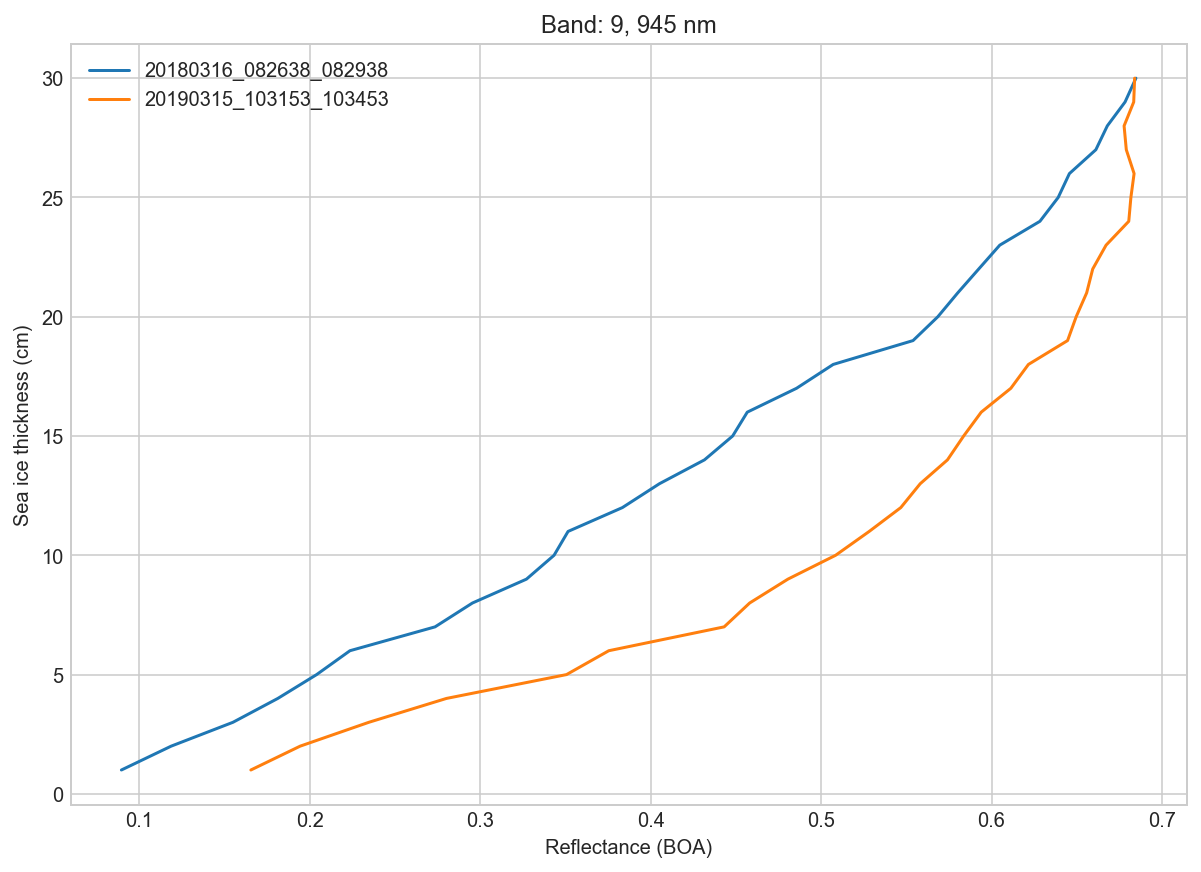

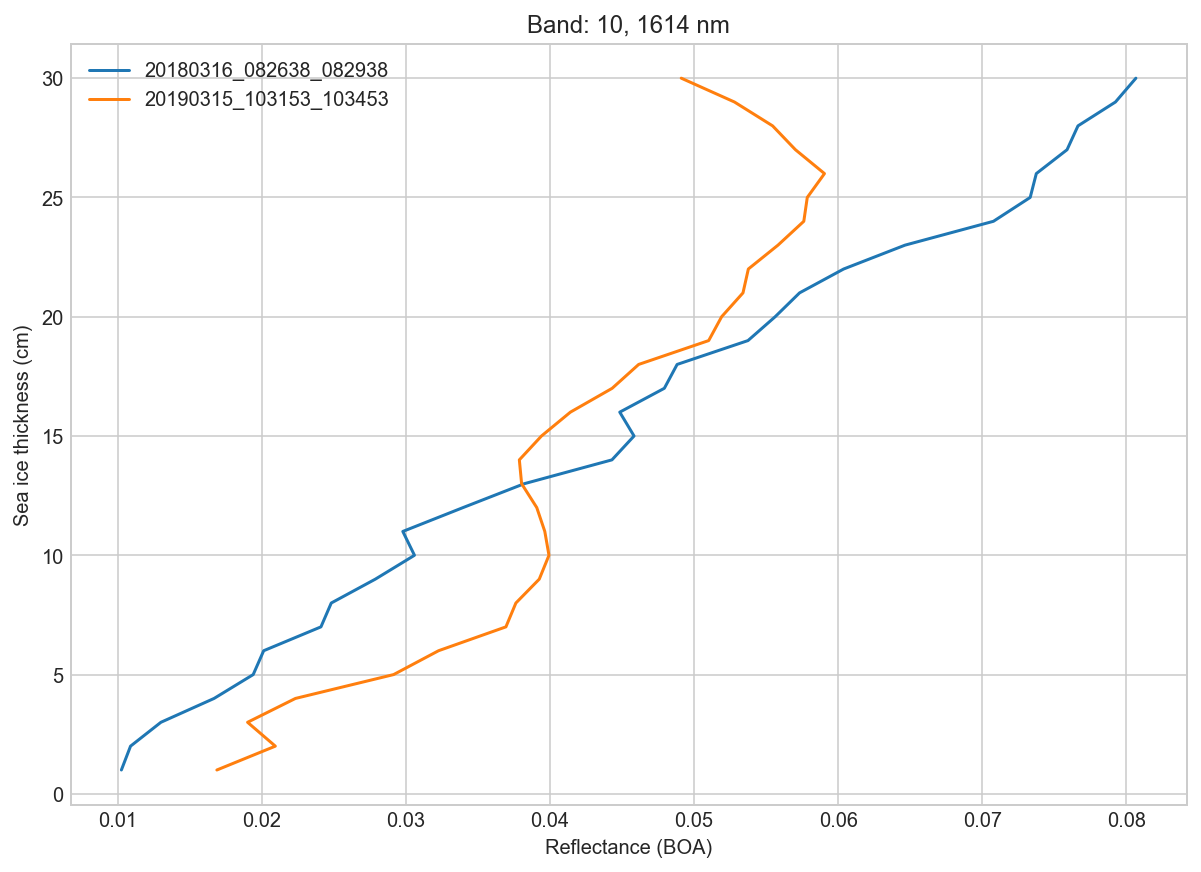

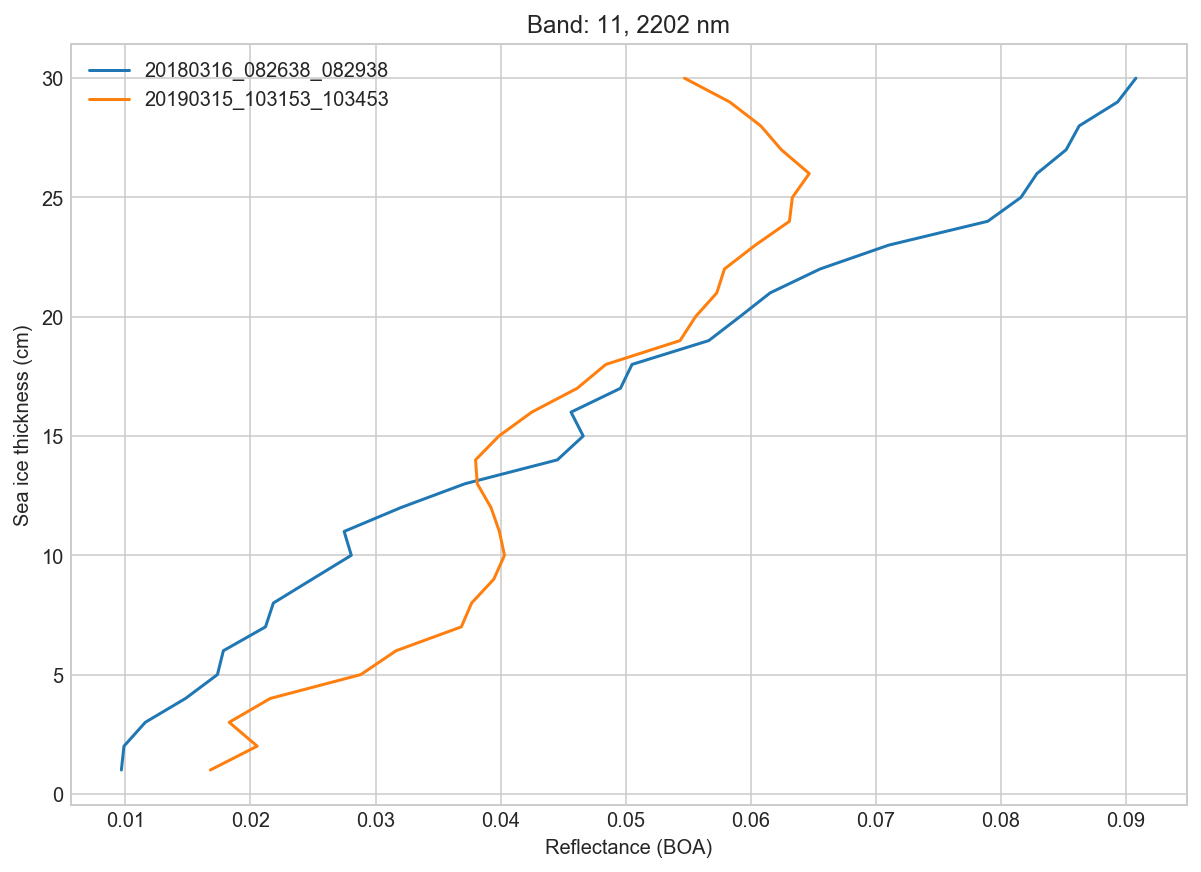

In [18]:
thin_ice_vals_iter, counts = np.unique(thin_SIT_vals[0], return_counts=True)
lambda_bands = [442, 492, 561, 665, 704, 740, 783, 833, 865, 945, 1373, 1614, 2202]
for i, band in enumerate(range(11)):
    plt.figure(figsize=(10, 7))
    plt.xlabel('Reflectance (BOA)')
    plt.ylabel('Sea ice thickness (cm)')
    for SITS2, vals, time in zip(thin_ice_S2, thin_SIT_vals, dates):
        mean_band = []
        standard_var_band = []
        for j, cmval in enumerate(thin_ice_vals_iter):
            thin_ice_cm = vals == cmval
            mean_band.append(np.mean(SITS2[thin_ice_cm, band]))
        plt.plot(mean_band,thin_ice_vals_iter, label=time)
        plt.title('Band: {}, {} nm'.format(i+1, lambda_bands2A[i]))
    plt.grid(True)
    plt.legend()
    
    

# Checking for possible curve fittings
#### Inverse log-, power- and exponential function

In [29]:
import scipy.optimize as optim
from sklearn.preprocessing import normalize

### Averaging the bands that have the most similar shapes

In [19]:
# Summing up the spectras the gives the best correlation between SIT and reflectanca (BOA)
x_arr = np.sum(S2_sit_array[:, :7], axis=1)/7
y_arr = thin_SIT_vals_arr

### Removing outliers on IQR based method

##### Removing data values that are higher than the 75th percentile value + 1.5 x IQR (Interquartile range) or lower than the 25th percentile  - 1.5 x IQR

$IQR = Q_3 - Q_1$
Where $Q_3$ is the limit of the 75th percentile and $Q_1$ is the limit of the 25th percentile

In [21]:
def reject_outlierIQR(x_data, y_data):
    
    data_collect = []
    
    green_diamond = dict(markerfacecolor='r', marker='D',markeredgewidth=0.0,fillstyle='full', markersize=2)
    for i, cmval in enumerate(thin_ice_vals_iter):
        thin_ice_cm = y_data == cmval
        data_collect.append(x_data[thin_ice_cm])
    plt.figure(figsize=(10,7))
    r = plt.boxplot(data_collect, vert=False, flierprops=green_diamond)
    plt.show()
    
    no_outlier = []
    no_out_sit = []
    for i, data_ in enumerate(r['fliers']):
        (out, sit) = data_.get_data()
        no_out = [x for x in data_collect[i] if x not in out]
        no_out_sit.append(np.ones((len(data_collect[i])-len(sit)))*(i+1))
        no_outlier.append(np.asarray(no_out))
    return no_outlier, no_out_sit


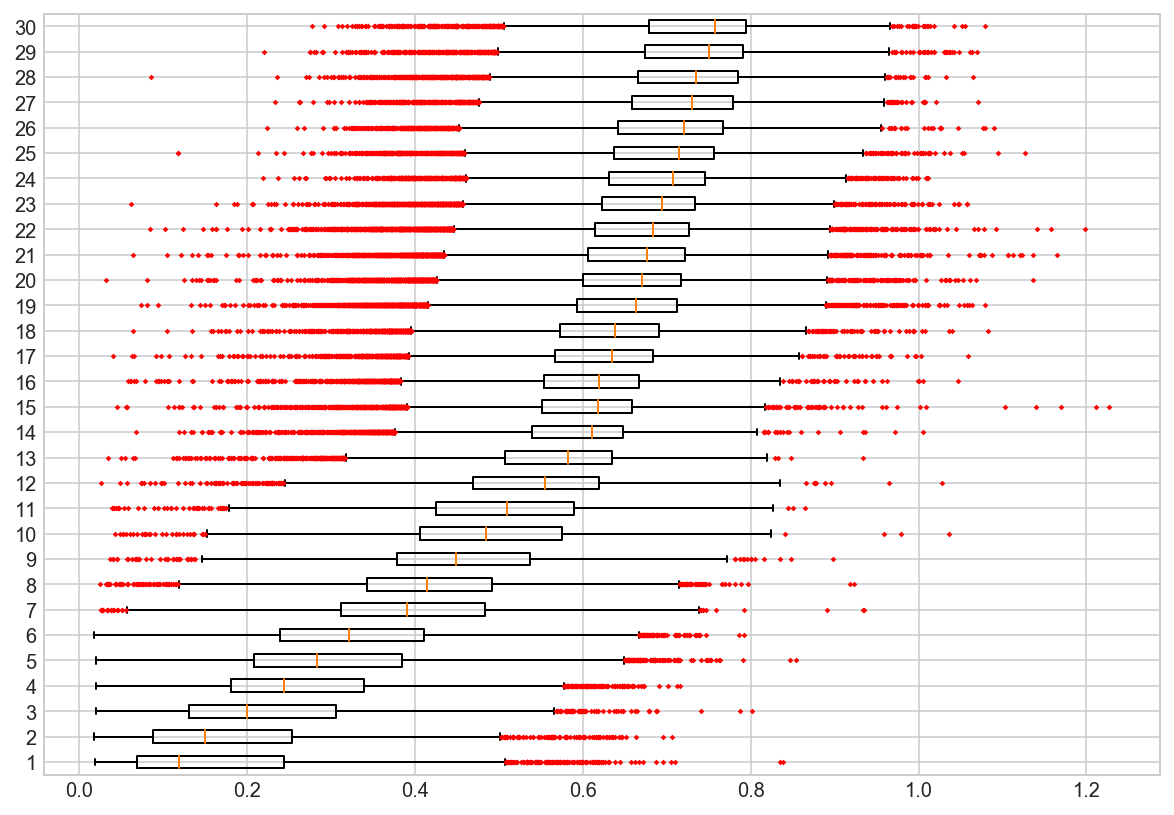

((312292,), (312292,))

In [22]:
no_out_x, no_out_y = reject_outlierIQR(x_arr, y_arr)
mean_x = []
std_x = []
for cm_x in no_out_x:
    mean_x.append(np.mean(cm_x))
    std_x.append(np.std(cm_x))
x_arr, y_arr = np.concatenate(no_out_x), np.concatenate(no_out_y)
x_arr.shape, y_arr.shape

### Rejecting outliers by assuming normal distribution for each thickness level
##### Removing the data that follows the condition:



$x_{\rho_{cm}} - \overline{x}_{\rho_{cm}} > m \cdot \sigma_{\rho_{cm}} $

Where defines a the area of the points you want to keep.



In [137]:
def reject_outliers(data, m=2):
    outliers_idx = (abs(data - np.mean(data)) < m * np.std(data))
    return data[outliers_idx], outliers_idx


mean_x=[]
std_x =[]
x_list=[]
y_list=[]
std_list=[]
for j, cmval in enumerate(thin_ice_vals_iter):
    thin_ice_cm = y_arr == cmval
    y_cm = y_arr[thin_ice_cm]
    x_data_ro, idx_ro = reject_outliers(x_arr[thin_ice_cm], m=2)
    x_list.append(x_data_ro)
    y_list.append(y_cm[idx_ro])
    std_list.append(np.ones(x_data_ro.shape)*np.std(x_data_ro))
    mean_x.append(np.mean(x_data_ro))
    std_x.append(np.std(x_data_ro))
    
    
    
x_arr = np.concatenate(x_list)
y_arr = np.concatenate(y_list)
std_arr = np.concatenate(std_list)
rand_idx = np.random.permutation(len(x_arr))
x_arr = x_arr[rand_idx]
y_arr = y_arr[rand_idx]
std_arr = std_arr[rand_idx]
print(x_arr.shape, y_arr.shape)

(102558,) (102558,)


Text(0, 0.5, 'Thin SIT (cm)')

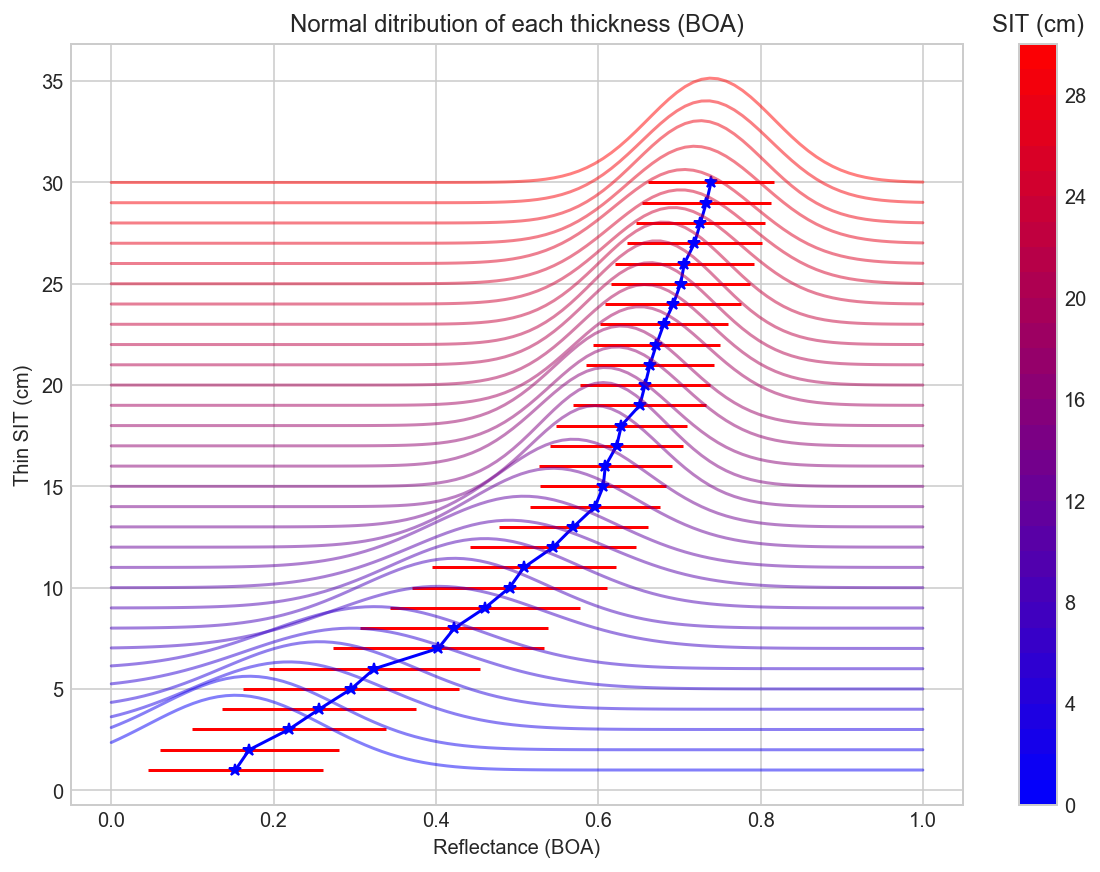

In [23]:
import scipy.stats as stats

plt.figure(figsize=(10, 7))
plt.errorbar(mean_x, thin_ice_vals_iter,fmt='none', xerr=std_x, ecolor='r')
plt.plot(mean_x, thin_ice_vals_iter, 'b*-')
norm_dist = []
x = np.linspace(0.0, 1.0, 100)

for (i, mean), std , z in zip(enumerate(mean_x), std_x, thin_ice_vals_iter):
    r = (float(z)-min_)/(max_-min_)
    g = 0
    b = 1-r
    #x = np.linspace(mean - 3*std, mean + 3*std, 100)
    p = stats.norm.pdf(x, mean, std)
    norm_dist.append(p)
    
    plt.plot(x, p + i+1, alpha=0.5, c=(r, g, b))

clb = plt.colorbar(CS3)
clb.ax.set_title('SIT (cm)')
plt.title("Normal ditribution of each thickness (BOA)")
plt.xlabel("Reflectance (BOA)")
plt.ylabel("Thin SIT (cm)")


In [24]:
from sklearn.linear_model import LinearRegression
x_data = S2_sit_array
y_data = thin_SIT_vals_arr
x_data.shape, y_data.shape

((322733, 11), (322733,))

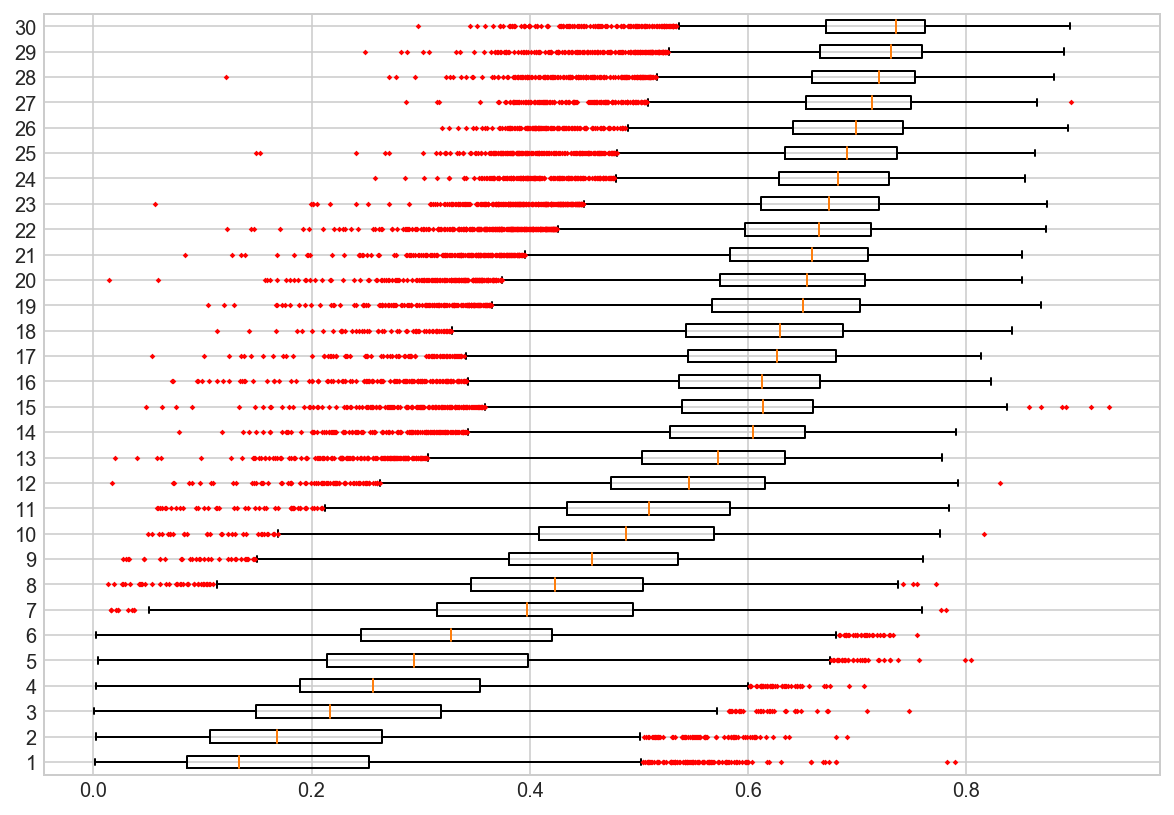

has 0.0:  False
intercept:  3.362845 , slope:  1.1864508
score:  0.6584439350497737


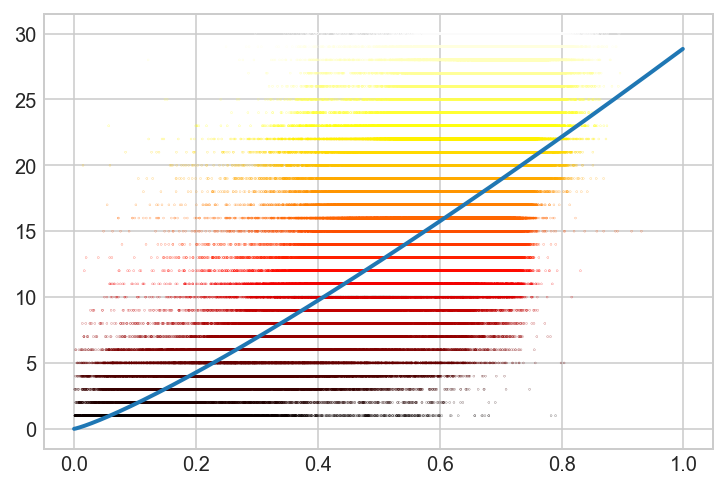

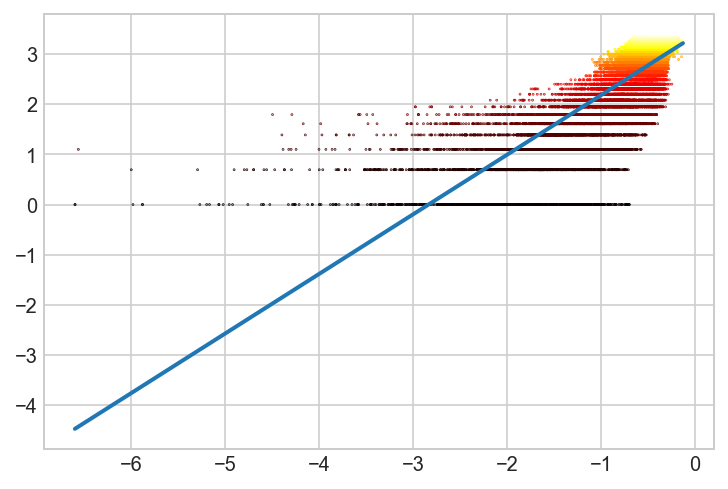

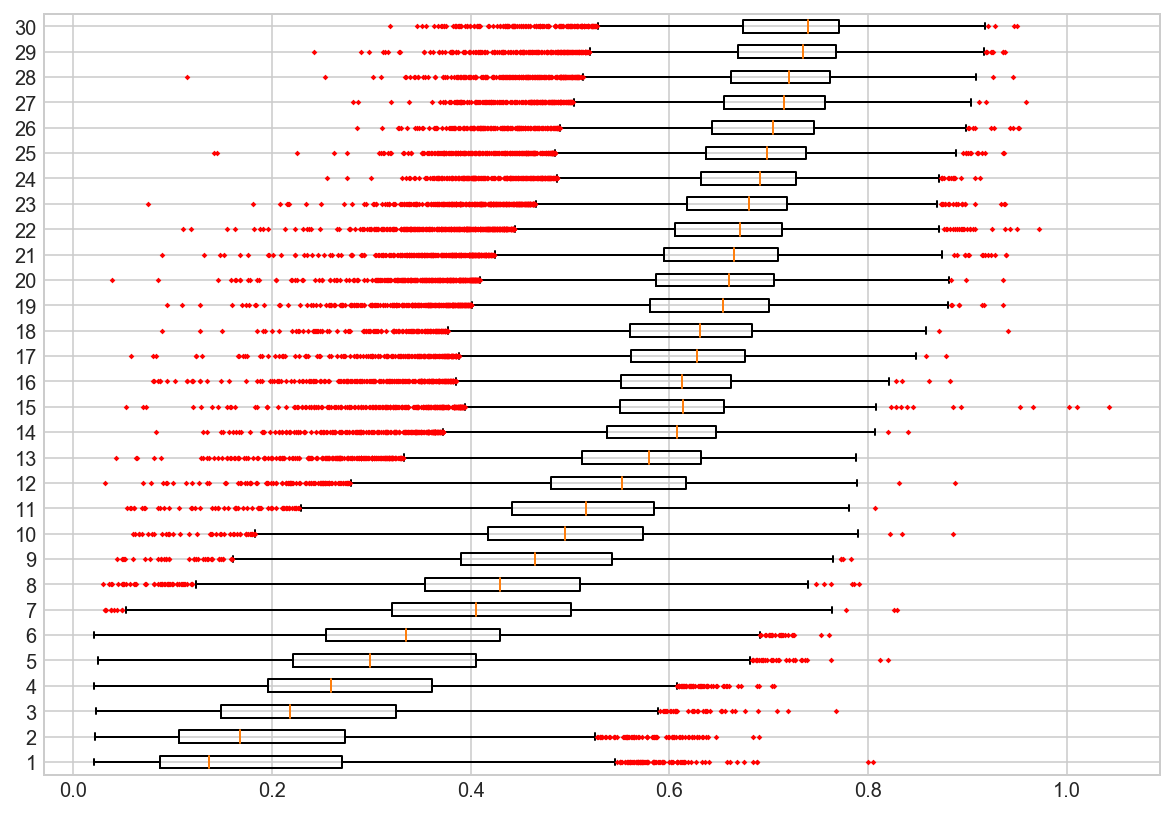

has 0.0:  False
intercept:  3.395773 , slope:  1.2542758
score:  0.6774477023995938


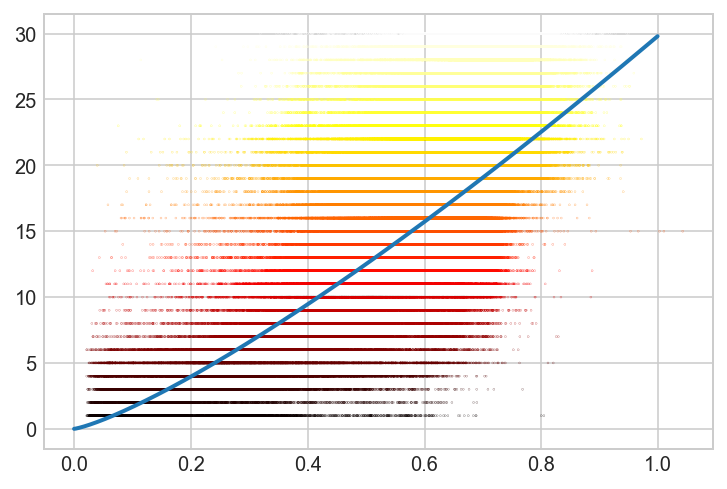

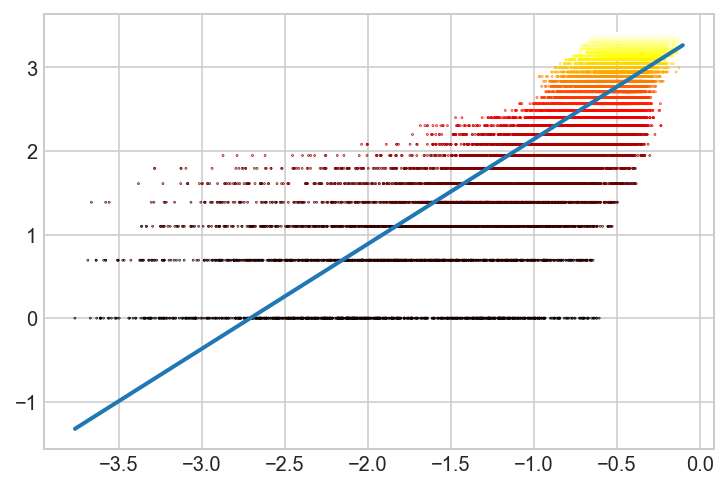

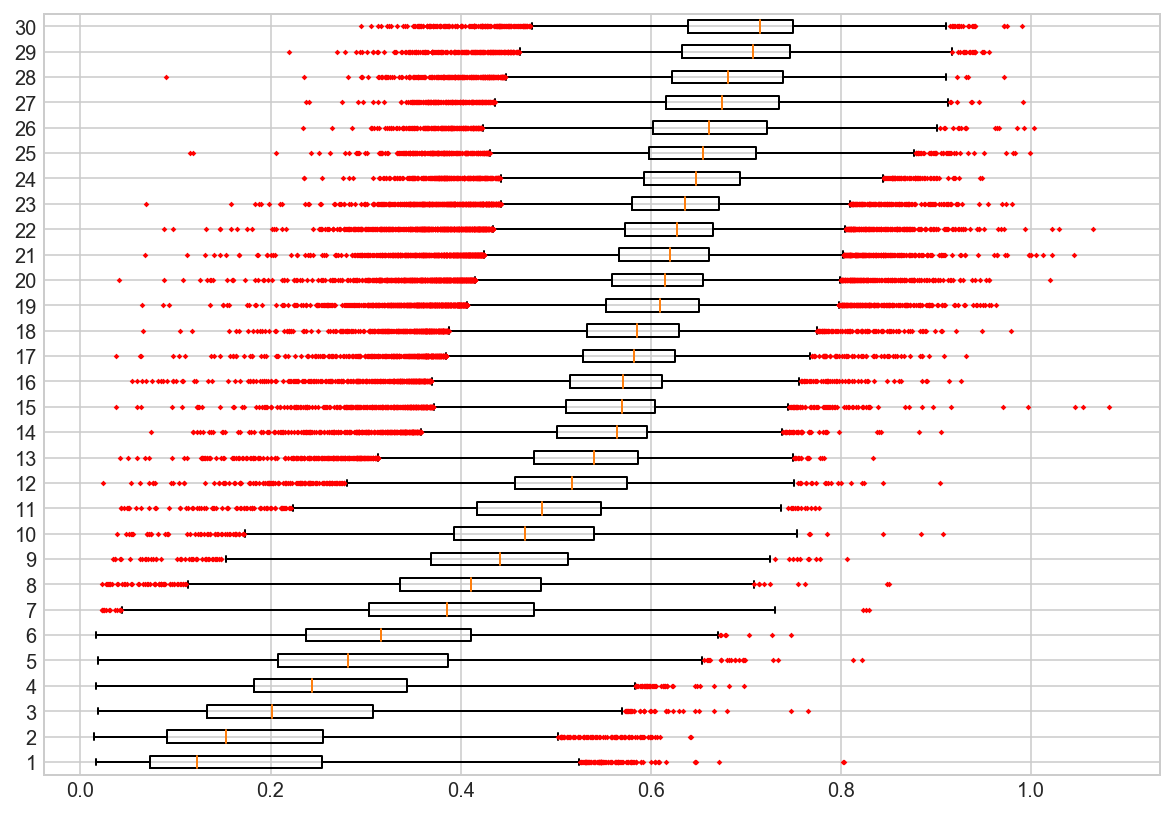

has 0.0:  False
intercept:  3.4208543 , slope:  1.1855267
score:  0.659685070431086


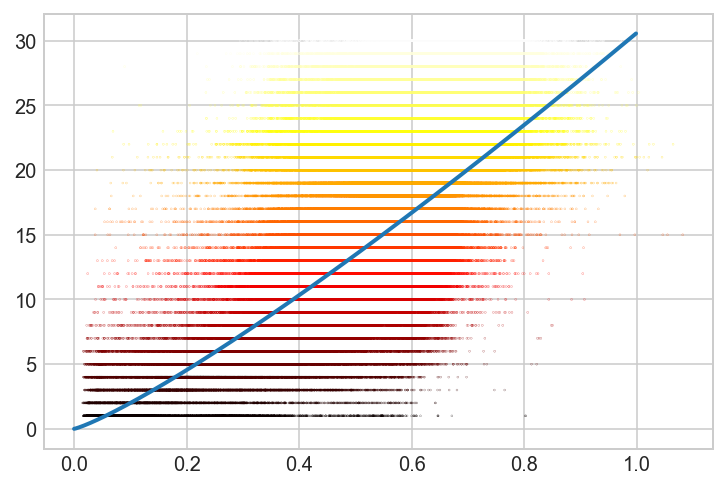

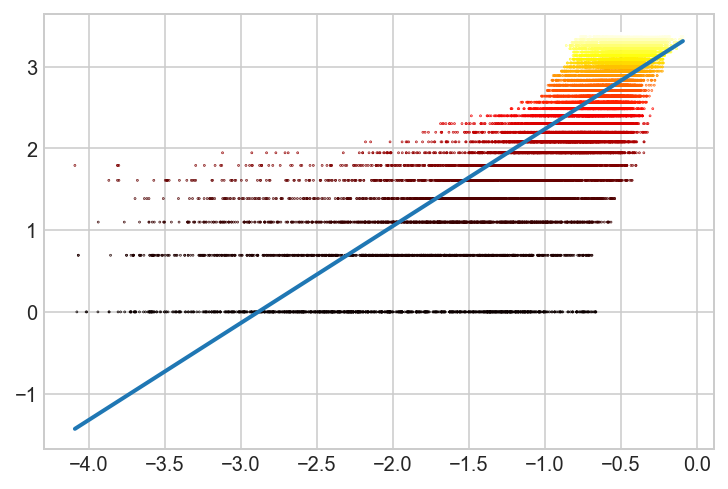

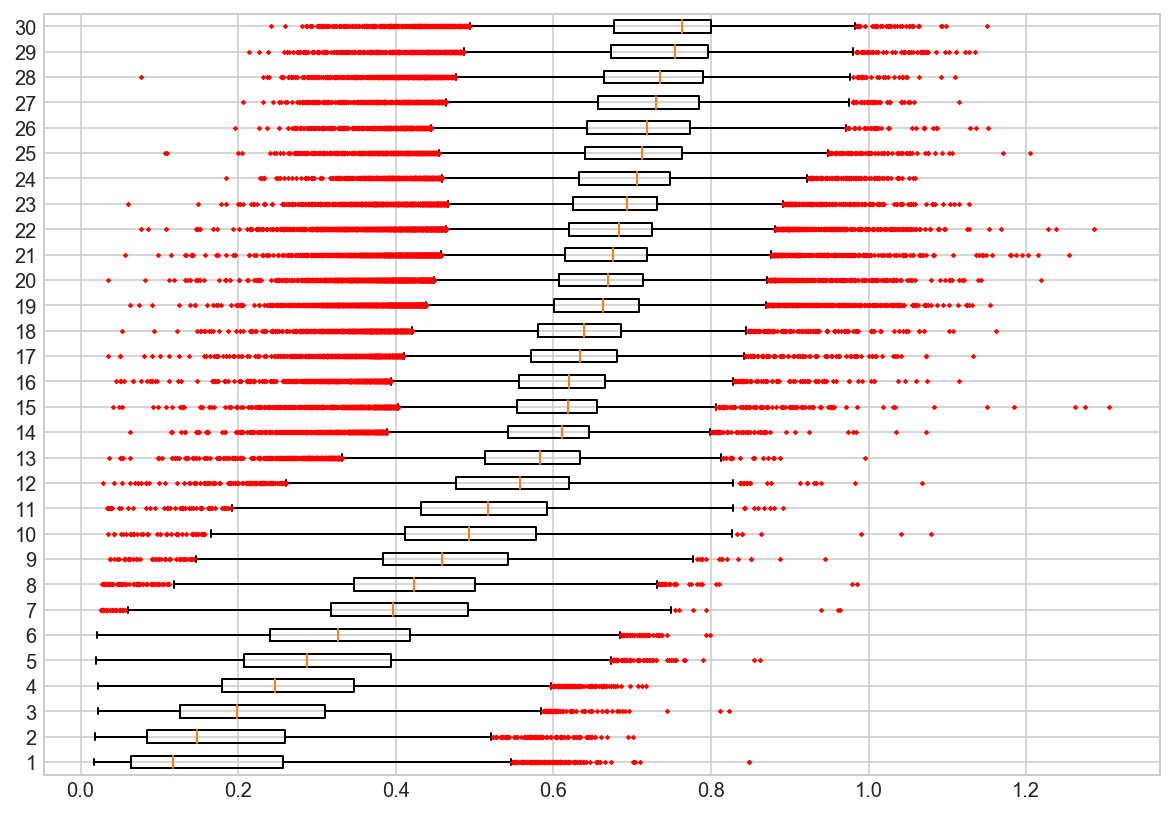

has 0.0:  False
intercept:  3.3036387 , slope:  1.1087174
score:  0.6622506756424498


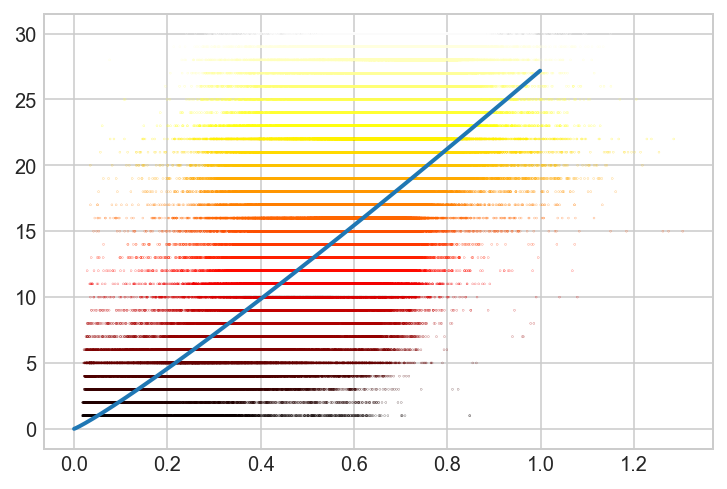

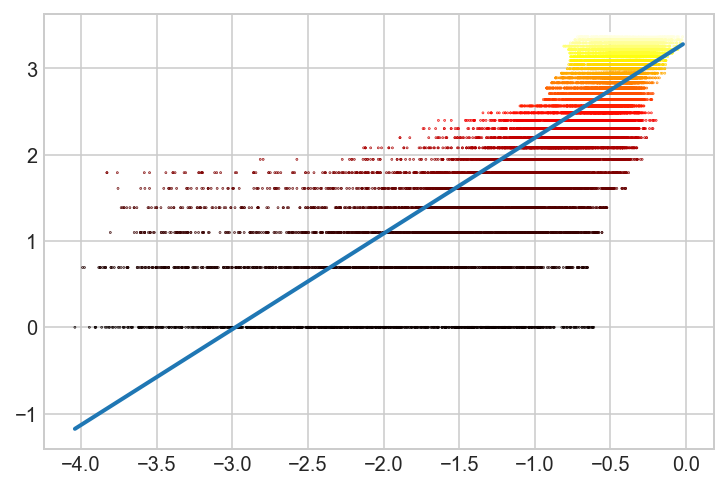

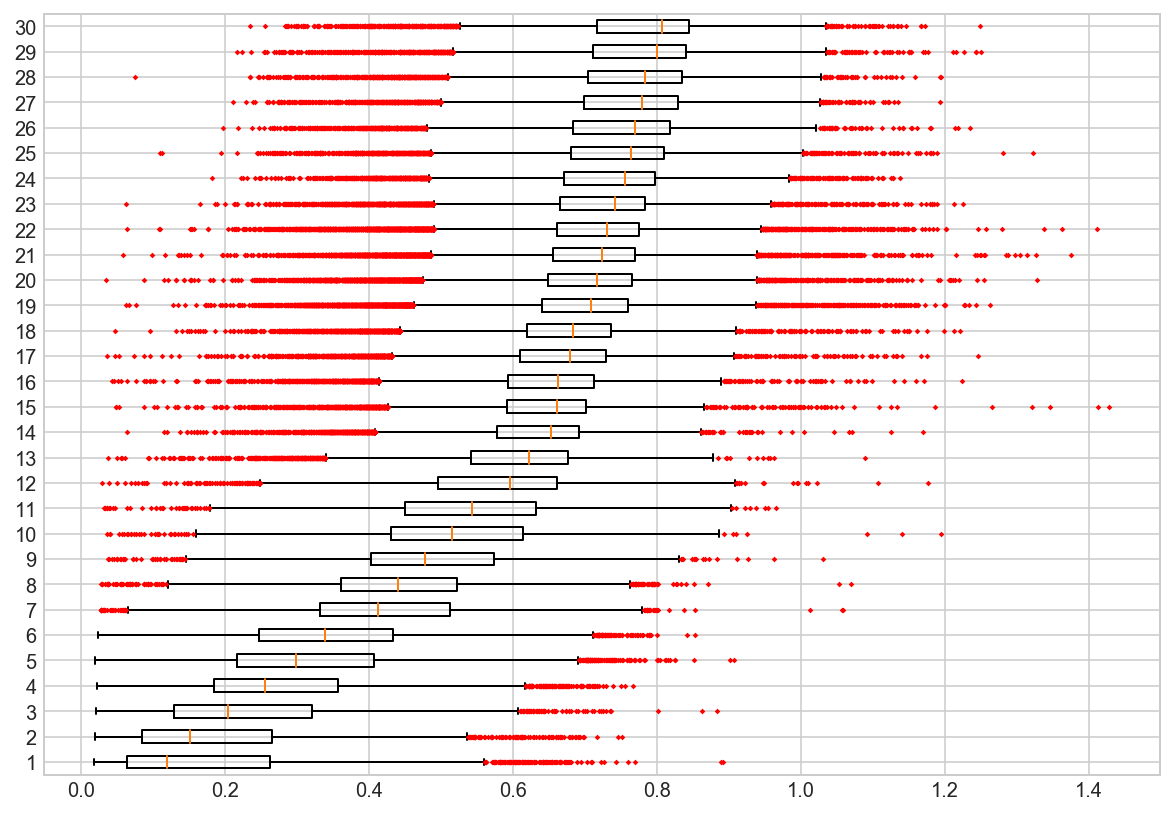

has 0.0:  False
intercept:  3.2356234 , slope:  1.0936869
score:  0.6751715948030523


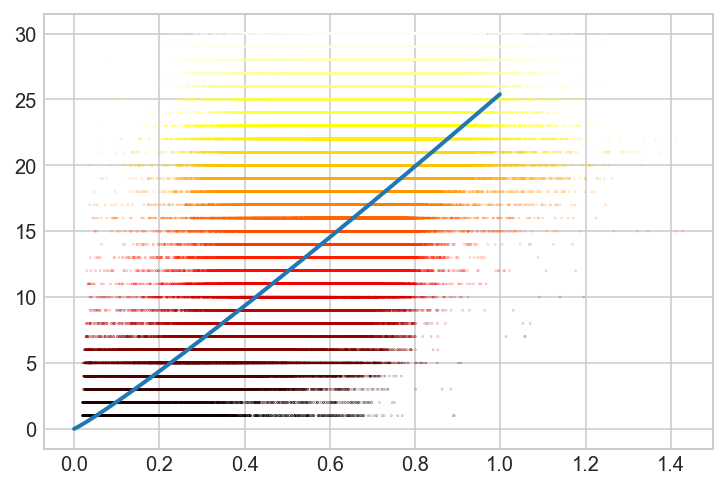

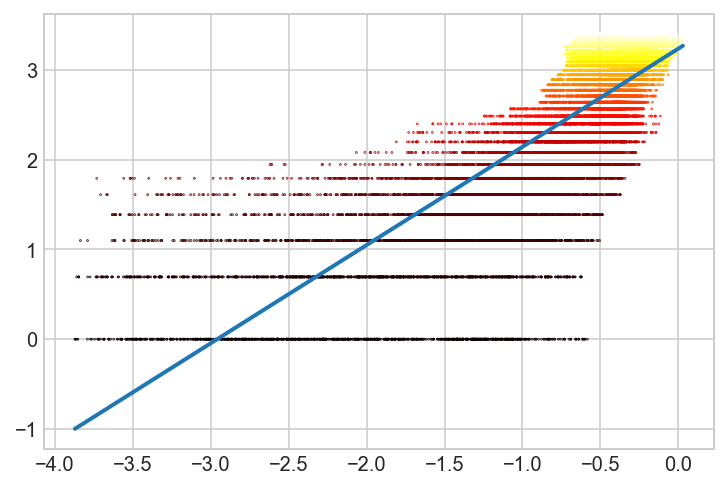

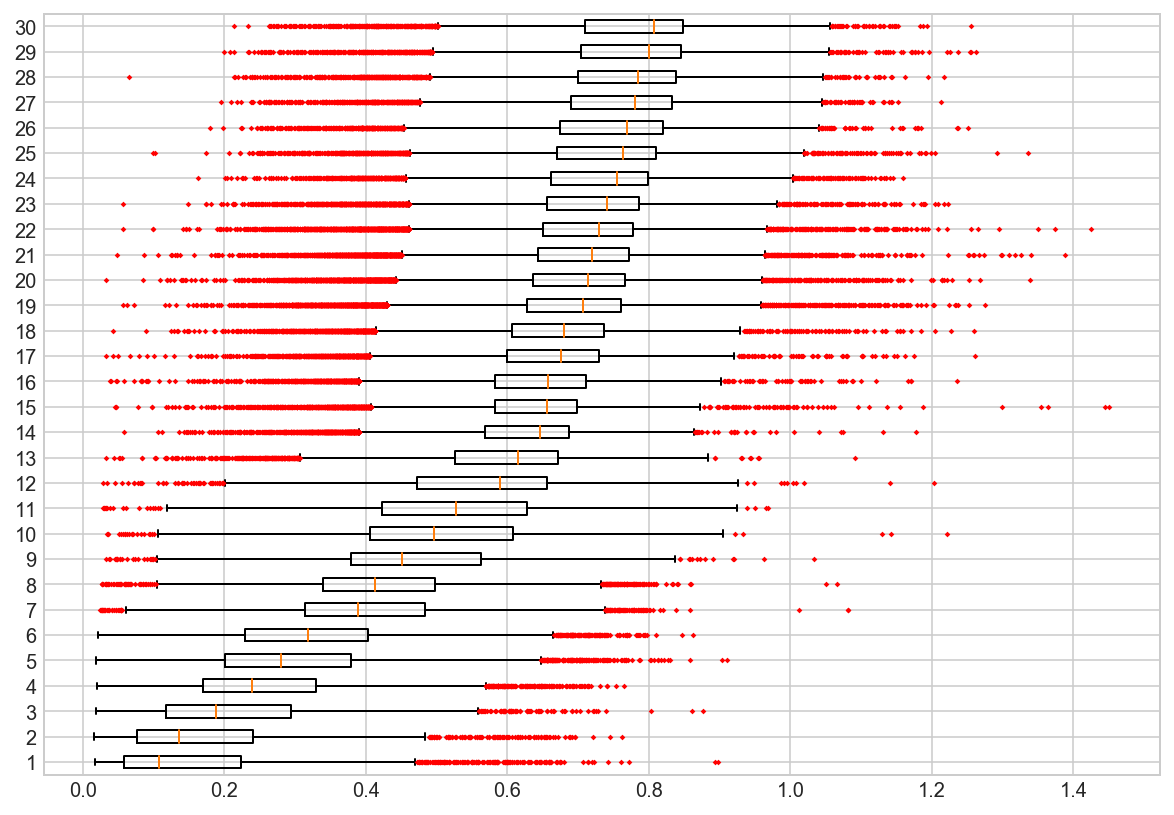

has 0.0:  False
intercept:  3.2448516 , slope:  1.0580702
score:  0.6982899198184598


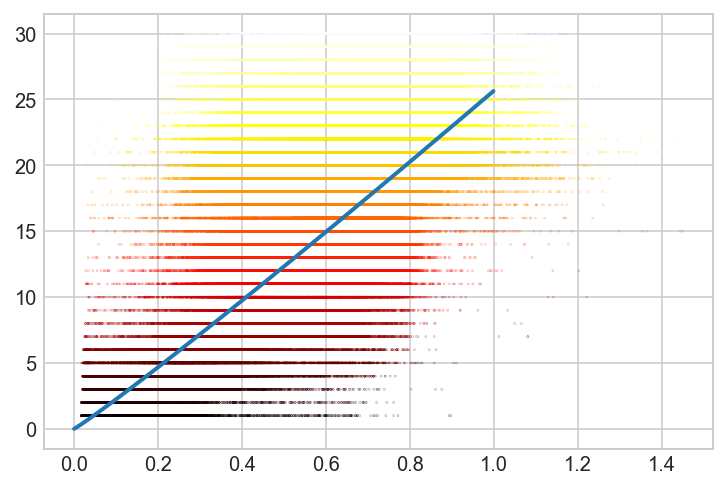

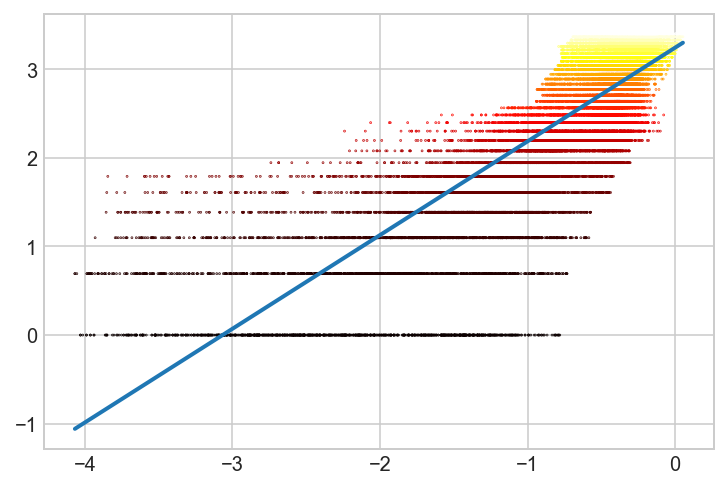

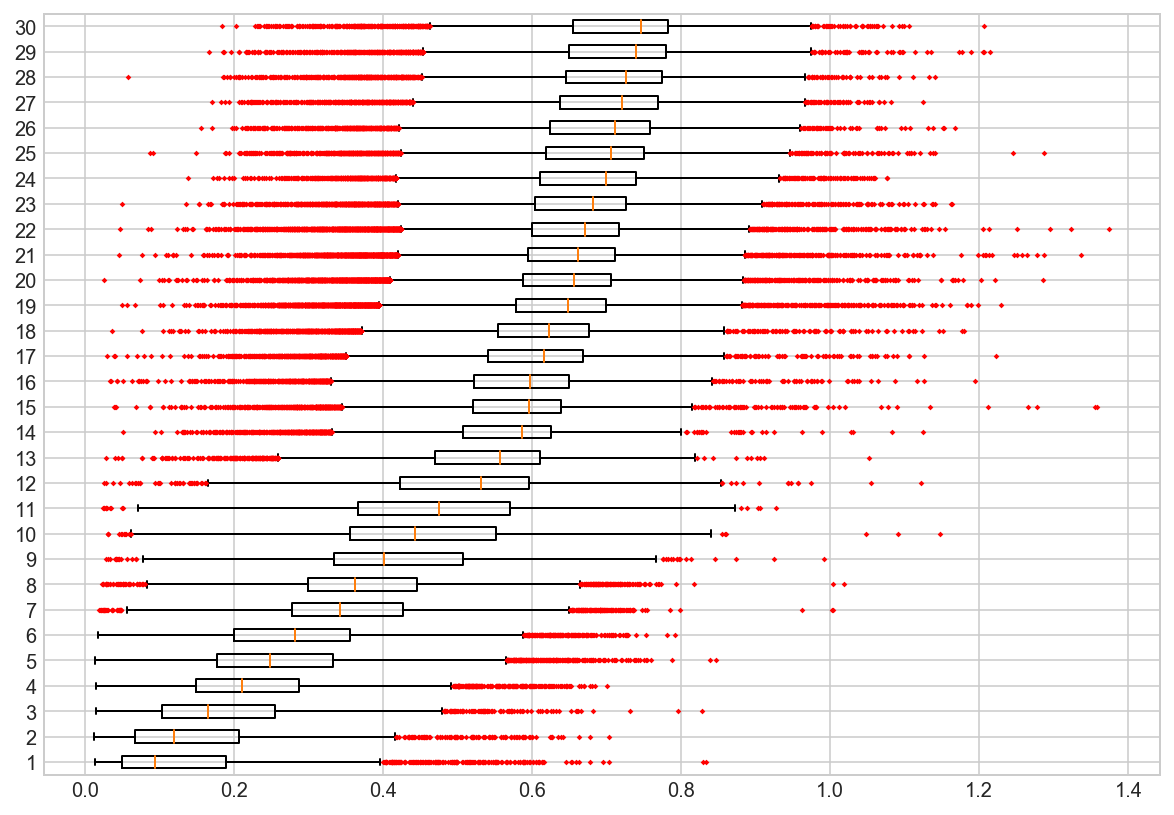

has 0.0:  False
intercept:  3.331557 , slope:  1.027769
score:  0.7092248753375796


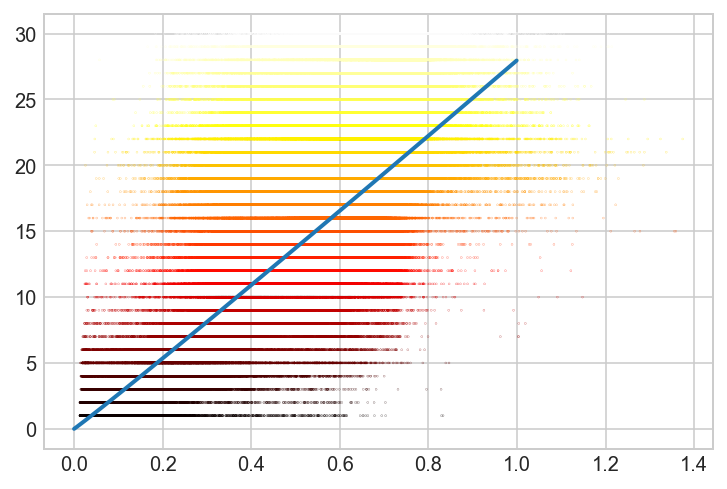

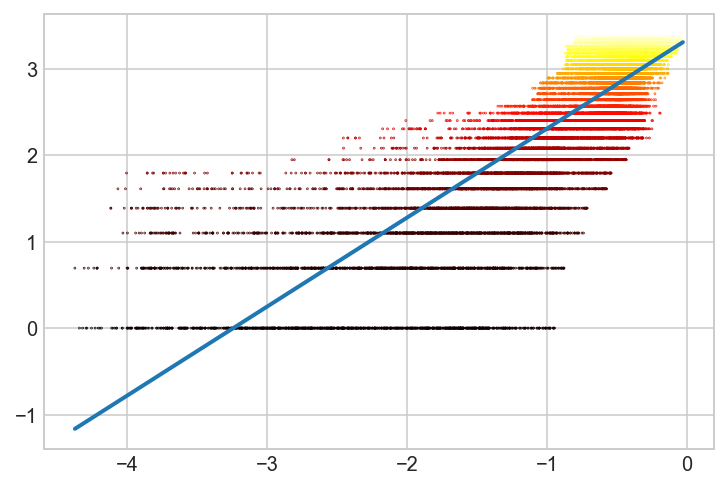

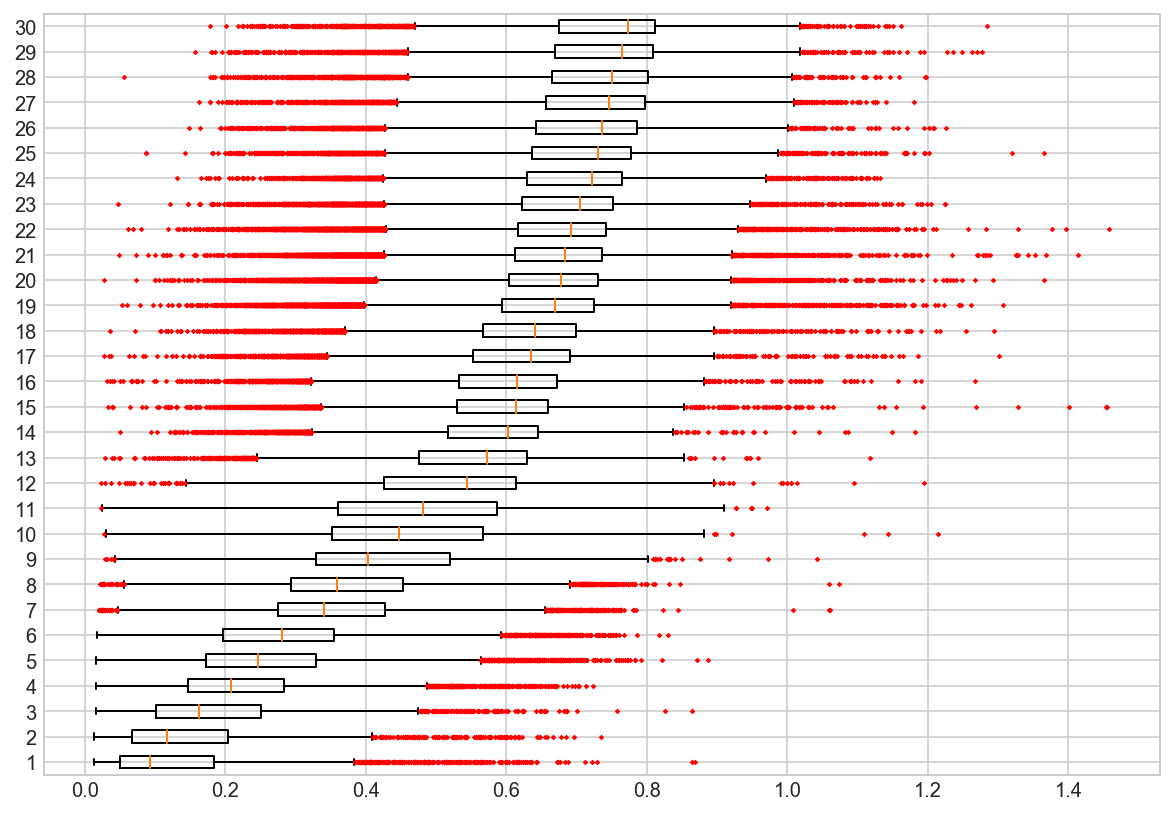

has 0.0:  False
intercept:  3.2918463 , slope:  0.9962801
score:  0.7114860185562439


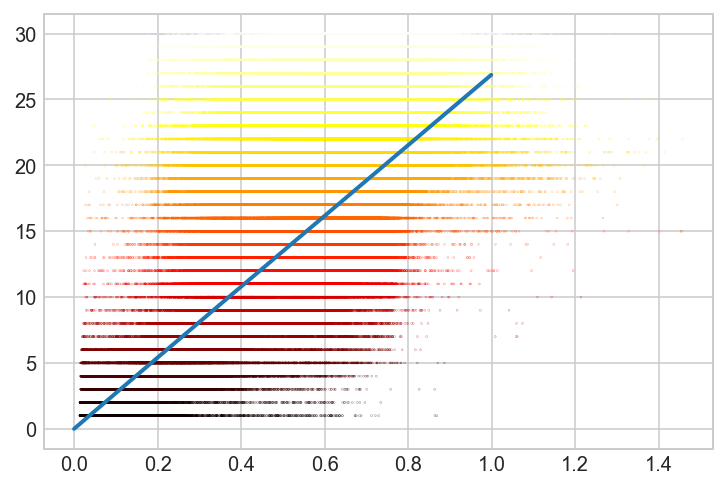

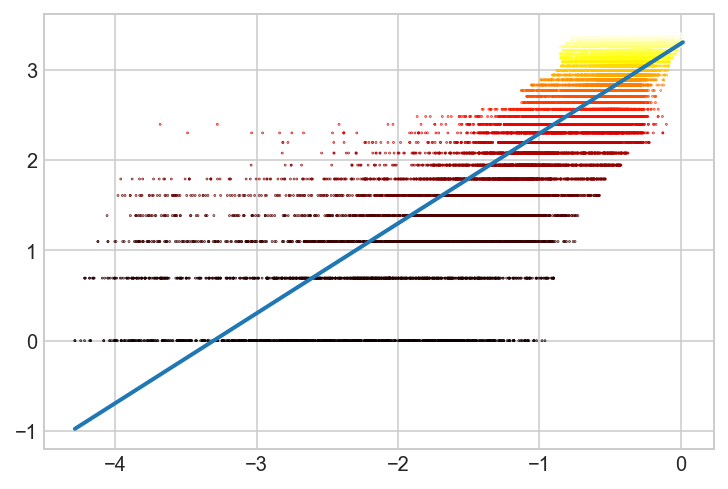

In [25]:
def reject_outlierIQR(x_data, y_data, sample):
    
    data_collect = []
    
    green_diamond = dict(markerfacecolor='r', marker='D',markeredgewidth=0.0,fillstyle='full', markersize=2)
    for i, cmval in enumerate(thin_ice_vals_iter):
        thin_ice_cm = y_data == cmval
        data_collect.append(x_data[thin_ice_cm])
    plt.figure(figsize=(10,7))
    r = plt.boxplot(data_collect, vert=False, flierprops=green_diamond)
    plt.show()
    
    no_outlier = []
    no_out_sit = []
    for i, data_ in enumerate(r['fliers']):
        (out, sit) = data_.get_data()
        no_out = [x for x in data_collect[i] if x not in out]
        idx = np.random.randint(0, len(no_out), sample)
        no_out_sit.append(np.ones((len(data_collect[i])-len(sit)))[idx]*(i+1))
        no_outlier.append(np.asarray(no_out)[idx])
    return no_outlier, no_out_sit

for i in range(8):
    
    no_out_x, no_out_y = reject_outlierIQR(x_data[:, i], y_data, 1000)
    mean_x = []
    std_x = []
    for cm_x in no_out_x:
        mean_x.append(np.mean(cm_x))
        std_x.append(np.std(cm_x))
    x_arr, y_arr = np.concatenate(no_out_x), np.concatenate(no_out_y)
    print("has 0.0: ", (x_arr <= 0.0).any())
    log_x = np.log(x_arr).reshape(-1,1)
    log_y = np.log(y_arr)
    model = LinearRegression()
    model.fit(log_x, log_y)

    print('intercept: ', model.intercept_,", slope: ", model.coef_[0])
    print('score: ', model.score(log_x, log_y))
    func = lambda x, a, b: np.exp(a)*(x)**b
    test = np.log(np.arange(np.min(x_arr), np.max(x_arr), 0.001)).reshape(-1,1)
    pred_test = model.predict(test)
    
    a_ = model.intercept_
    b_ = model.coef_
    
    test_x = np.arange(0, 1, 0.001)
    plt.figure()
    plt.plot(test_x, func(test_x, a_, b_), linewidth=2)
    plt.scatter(x_data[:,i], y_data,s=0.01, c=y_data, cmap='hot')

    plt.figure()
    plt.plot(test, pred_test, linewidth=2)
    plt.scatter(log_x, log_y, s=0.1, c=y_arr, cmap='hot')

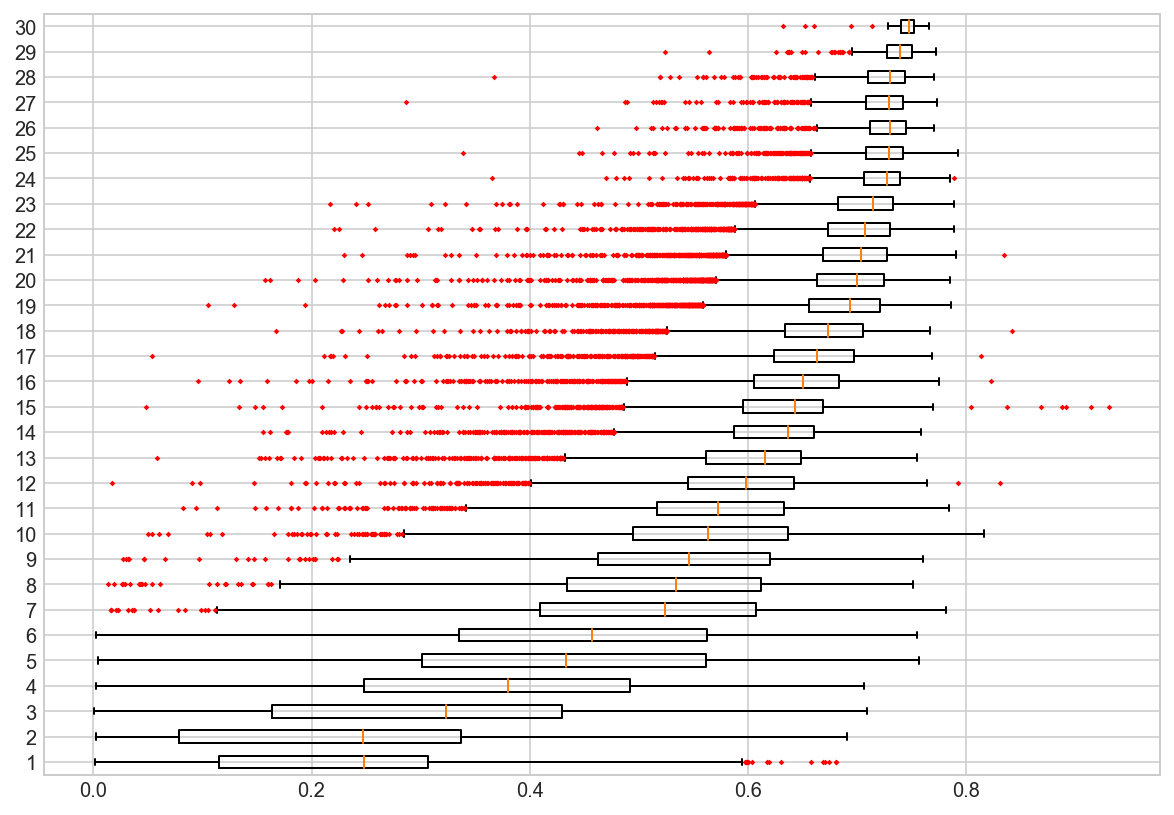

has 0.0:  True
intercept:  3.257144 , slope:  1.0790963
score:  0.49952177640226236


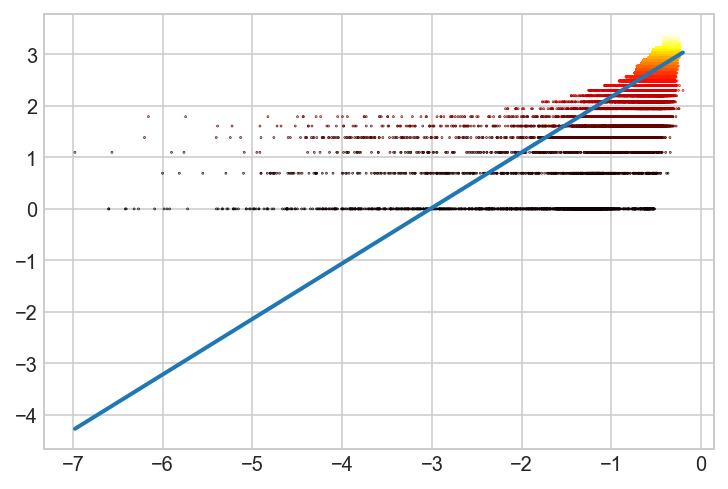

In [211]:
no_out_x, no_out_y = reject_outlierIQR(x_data[:, 0], y_data)
mean_x = []
std_x = []
for cm_x in no_out_x:
    mean_x.append(np.mean(cm_x))
    std_x.append(np.std(cm_x))
x_arr, y_arr = np.concatenate(no_out_x), np.concatenate(no_out_y)
print("has 0.0: ", (x_arr <= 0.0).any())
log_x = np.log(x_arr).reshape(-1,1)
log_y = np.log(y_arr)
model = LinearRegression()
model.fit(log_x, log_y)

print('intercept: ', model.intercept_,", slope: ", model.coef_[0])
print('score: ', model.score(log_x, log_y))

test = np.log(np.arange(np.min(x_arr), np.max(x_arr), 0.001)).reshape(-1,1)


In [26]:
#a = model.intercept_
#b = model.coef_[0]
model = LinearRegression()
model.fit(np.log(mean_x).reshape(-1,1), np.log(thin_ice_vals_iter))
a_ = model.intercept_
b_ = model.coef_[0]
print(model.score(log_x, log_y))

0.4819065956459493


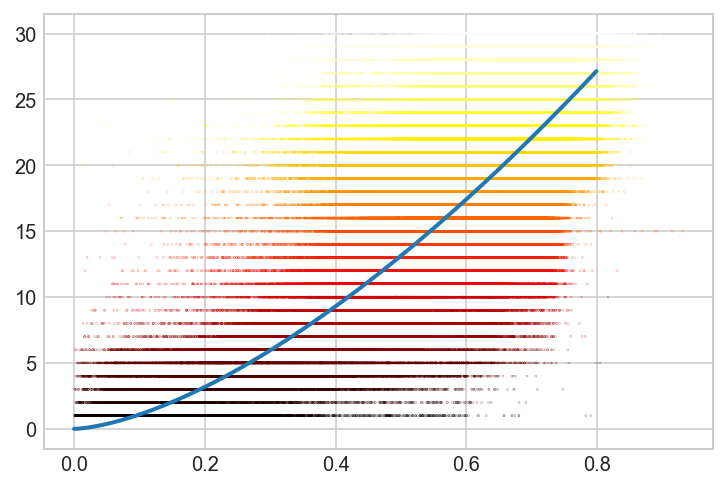

In [27]:
test_x = np.arange(0, 0.8, 0.001)
plt.figure()
plt.plot(test_x, func(test_x, a_, b_), linewidth=2)
plt.scatter(x_data[:,0], y_data,s=0.01, c=y_data, cmap='hot')

In [33]:
curveExp, var_matrixExp = optim.curve_fit(lambda t,a,b,c: a*np.exp(b*t)+c,  x_arr,  y_arr)

curvePow,var_matrixPow = optim.curve_fit(lambda t, a, b, c, d: a*((t+d)**b)+c, x_arr, y_arr)

#curveLog,var_matrixLog = optim.curve_fit(lambda t, L, k, x_0: x_0 - (np.log((L/t)-1)/k), x_arr, y_arr)

curvePoly= np.polyfit(x_arr, y_arr, deg=6, full=True)
# Minimize sum of square error
SEExp = np.sqrt(np.diagonal(var_matrixExp))
SEPow = np.sqrt(np.diagonal(var_matrixPow))
#SELog = np.sqrt(np.diagonal(var_matrixLog))



Expfunc = lambda x, curve: curve[0]*np.exp(curve[1]*x) + curve[2]
Powfunc = lambda x, curve: curve[0]*((x+curve[3])**curve[1]) + curve[2]
#Logfunc = lambda x, curve: curve[2]-(np.log((curve[0]/x)-1)/curve[1])
#LogDer = lambda x, curve: curve[0]/(curve[1]*curve[0]*x-curve[1]*x**2)
#LogDerDer = lambda x, curve: (curve[0]*(curve[0]-2*x))/(curve[1]*x**2*(curve[0]-x)**2)

print("Standard error for exp:", SEExp)
print("Standard error for pow:", SEPow)
#print("Standard error for log:", SELog)

Standard error for exp: [inf inf inf]
Standard error for pow: [inf inf inf inf]


In [34]:
Polyfunc = lambda x, curve: curve[0][0]*x**6+curve[0][1]*x**5 + curve[0][2]*x**4 + curve[0][3]*x**3+ curve[0][4]*x**2 + curve[0][5]*x + curve[0][6]

In [35]:
curvePow

array([1., 1., 1., 1.])

<IPython.core.display.Javascript object>


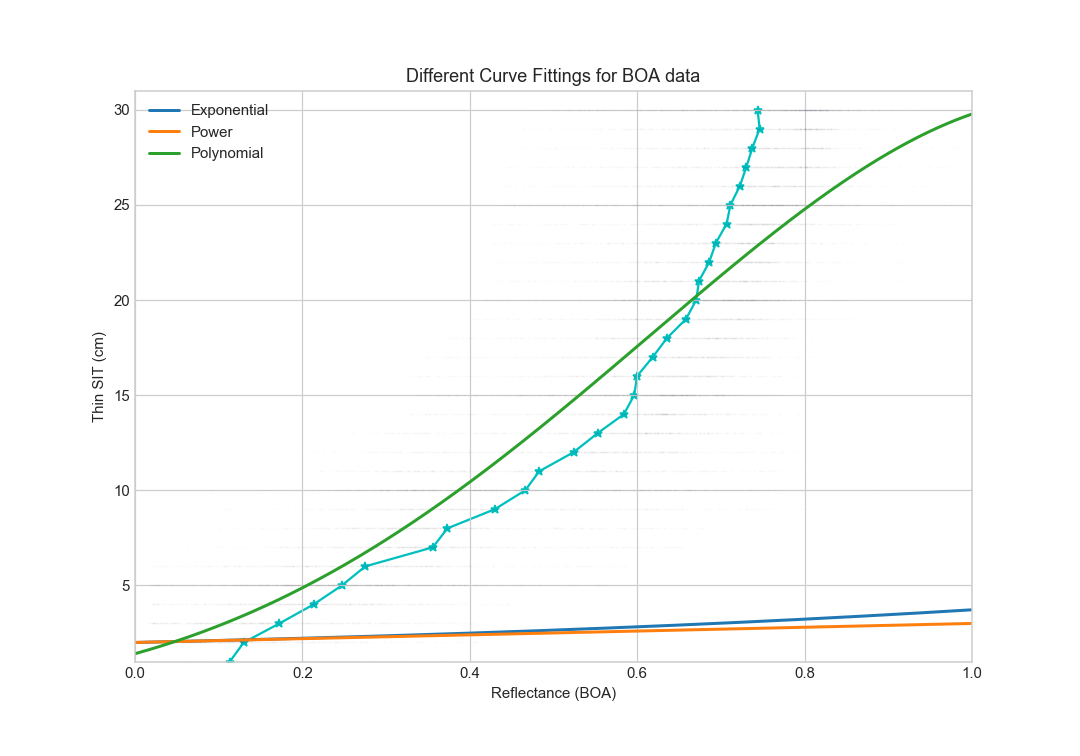

(0, 1)

In [94]:
test=np.arange(0.0, 1.0, 0.001)
plt.figure(figsize=(10, 7))
plt.plot(test, Expfunc(test, curveExp),linewidth = 2, label='Exponential')
plt.plot(test, Powfunc(test, curvePow),linewidth = 2, label='Power')
plt.plot(test, Polyfunc(test, curvePoly), linewidth = 2, label='Polynomial')
#plt.plot(test, Logfunc(test, curveLog),linewidth = 2, label='Logit')
#plt.plot(test, LogDer(test, curveLog), linewidth = 2, label='Derivitive of logit')
#plt.plot(test, LogDerDer(test, curveLog), linewidth = 2, label='Sec. Derivitive of logit')
plt.scatter(x_arr, y_arr, s=0.1, alpha=0.01)
plt.plot(mean_x, thin_ice_vals_iter, 'c-*', zorder=0)
plt.legend()
plt.title("Different Curve Fittings for BOA data")
plt.xlabel("Reflectance (BOA)")
plt.ylabel("Thin SIT (cm)")
plt.ylim([1, 31])
plt.xlim([0, 1])



## 